# **Problem 3: Self Organizing Map (SOM)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from zipfile import ZipFile
import requests
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score, silhouette_score, confusion_matrix

Load dataset

In [2]:
# Direct link to the ZIP file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

# Download and extract the ZIP content
zip_response  = requests.get(url)
with ZipFile(BytesIO(zip_response .content)) as zip_file:
    with zip_file.open('bank-additional/bank-additional-full.csv') as csv_file:
        bank_data = pd.read_csv(csv_file, sep=';')  # Use ';' as the field delimiter

print(bank_data.head())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

Preprocessing

In [3]:
print(bank_data.shape)

(41188, 21)


In [4]:
# Count 'unknown' values in each column
unknown_counts = (bank_data == 'unknown').sum()
print("\nUnknown values in each column:")
print(unknown_counts[unknown_counts > 0])


Unknown values in each column:
job           330
marital        80
education    1731
default      8597
housing       990
loan          990
dtype: int64


In [5]:
# List of columns with 'unknown' values
columns_with_unknown = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Replace 'unknown' values with the mode of each column
for column in columns_with_unknown:
    most_frequent_value = bank_data[column].mode()[0]  # Get the most frequent value
    bank_data[column] = bank_data[column].replace('unknown', most_frequent_value)

print(bank_data.head())

unknown_counts = (bank_data == 'unknown').sum()
print("\nUnknown values in each column:")
print(unknown_counts[unknown_counts > 0])

   age        job  marital    education default housing loan    contact month  \
0   56  housemaid  married     basic.4y      no      no   no  telephone   may   
1   57   services  married  high.school      no      no   no  telephone   may   
2   37   services  married  high.school      no     yes   no  telephone   may   
3   40     admin.  married     basic.6y      no      no   no  telephone   may   
4   56   services  married  high.school      no      no  yes  telephone   may   

  day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0         mon  ...         1    999         0  nonexistent          1.1   
1         mon  ...         1    999         0  nonexistent          1.1   
2         mon  ...         1    999         0  nonexistent          1.1   
3         mon  ...         1    999         0  nonexistent          1.1   
4         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  

In [6]:
# Identify non-numeric columns
non_numeric_columns = bank_data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

Non-numeric columns: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


In [7]:
# Apply LabelEncoder to binary columns
label_columns = ['default', 'housing', 'loan', 'y']
label_encoder = LabelEncoder()

for column in label_columns:
    bank_data[column] = label_encoder.fit_transform(bank_data[column])

# Apply OneHotEncoder to multi-category columns
one_hot_columns = ['job', 'education', 'contact', 'month', 'day_of_week', 'poutcome', 'marital']
bank_data = pd.get_dummies(bank_data, columns=one_hot_columns, drop_first=True)  

print(bank_data.head())

   age  default  housing  loan  duration  campaign  pdays  previous  \
0   56        0        0     0       261         1    999         0   
1   57        0        0     0       149         1    999         0   
2   37        0        1     0       226         1    999         0   
3   40        0        0     0       151         1    999         0   
4   56        0        0     1       307         1    999         0   

   emp.var.rate  cons.price.idx  ...  month_oct  month_sep  day_of_week_mon  \
0           1.1          93.994  ...      False      False             True   
1           1.1          93.994  ...      False      False             True   
2           1.1          93.994  ...      False      False             True   
3           1.1          93.994  ...      False      False             True   
4           1.1          93.994  ...      False      False             True   

   day_of_week_thu  day_of_week_tue  day_of_week_wed  poutcome_nonexistent  \
0            False  

In [8]:
# Copy the final DataFrame
df_final = bank_data.copy()

# Normalize the DataFrame using Min-Max Scaling
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

print("df_scaled shape:", df_scaled.shape)
print(df_scaled.head())

df_scaled shape: (41188, 48)
        age  default  housing  loan  duration  campaign  pdays  previous  \
0  0.481481      0.0      0.0   0.0  0.053070       0.0    1.0       0.0   
1  0.493827      0.0      0.0   0.0  0.030297       0.0    1.0       0.0   
2  0.246914      0.0      1.0   0.0  0.045954       0.0    1.0       0.0   
3  0.283951      0.0      0.0   0.0  0.030704       0.0    1.0       0.0   
4  0.481481      0.0      0.0   1.0  0.062424       0.0    1.0       0.0   

   emp.var.rate  cons.price.idx  ...  month_oct  month_sep  day_of_week_mon  \
0        0.9375        0.698753  ...        0.0        0.0              1.0   
1        0.9375        0.698753  ...        0.0        0.0              1.0   
2        0.9375        0.698753  ...        0.0        0.0              1.0   
3        0.9375        0.698753  ...        0.0        0.0              1.0   
4        0.9375        0.698753  ...        0.0        0.0              1.0   

   day_of_week_thu  day_of_week_tue  da

In [9]:
# Separate features and label
X = df_scaled.drop('y', axis=1)
y = df_scaled['y']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (32950, 47)
Test shape: (8238, 47)


# Part 1:

In [ ]:
class SOM:
    def __init__(self, grid_shape, input_dim, learning_rate=0.5, radius=1.0, max_iter=1000, neighborhood_func=None):
        # Initialize SOM parameters
        self.grid_shape = grid_shape
        self.input_dim = input_dim 
        self.learning_rate = learning_rate
        self.radius = radius   # Neighborhood radius
        self.max_iter = max_iter  
        self.neighborhood_func = neighborhood_func or self.default_neighborhood 
        self.weights = np.random.rand(grid_shape[0], grid_shape[1], input_dim)   # Initialize weights

    # Calculate Euclidean distance
    def euclidean_distance(self, x, y):
        return np.linalg.norm(x - y)

    # Default Gaussian neighborhood function
    def default_neighborhood(self, distance, radius):
        return np.exp(-(distance**2) / (2 * (radius**2)))

    # Find the Best Matching Unit (BMU) for input x
    def find_bmu(self, x):
        distances = np.linalg.norm(self.weights - x.reshape(1, 1, self.input_dim), axis=2)
        return np.unravel_index(np.argmin(distances), self.grid_shape)

    # Compute the neighborhood function based on BMU and iteration
    def compute_neighborhood(self, bmu_idx, iteration):
        sigma = self.radius * np.exp(-iteration / self.max_iter)  
        learning_rate = self.learning_rate * np.exp(-iteration / self.max_iter) 

        neighborhood = np.zeros(self.grid_shape)
        for i in range(self.grid_shape[0]):
            for j in range(self.grid_shape[1]):
                dist_sq = (i - bmu_idx[0]) ** 2 + (j - bmu_idx[1]) ** 2
                neighborhood[i, j] = self.neighborhood_func(np.sqrt(dist_sq), sigma)
        return neighborhood * learning_rate

    # Train the SOM model
    def train(self, X):
        for iteration in range(self.max_iter):
            x = X.iloc[np.random.randint(0, X.shape[0])].values   # Select random data point
            bmu_idx = self.find_bmu(x)
            neighborhood = self.compute_neighborhood(bmu_idx, iteration)

            # Update weights for each neuron
            for i in range(self.grid_shape[0]):
                for j in range(self.grid_shape[1]):
                    self.weights[i, j] += neighborhood[i, j] * (x - self.weights[i, j])

            if iteration % 100 == 0:
                self.visualize(iteration)

    # Transform input data to BMU indices
    def transform(self, X):
        transformed = []
        for x in X.values:
            bmu = self.find_bmu(x)
            transformed.append(bmu)
        return np.array(transformed)

    # Visualize SOM weights
    def visualize(self, iteration):
        plt.imshow(np.linalg.norm(self.weights - self.weights.mean(axis=(0, 1)), axis=2))
        plt.title(f"Iteration {iteration}")
        plt.colorbar()
        plt.show()

Train classifier without dimensionality reduction

Training Time: 5.5987 seconds
Accuracy: 0.9116
Adjusted Rand Index (ARI): 0.4479
Silhouette Score: 0.0756


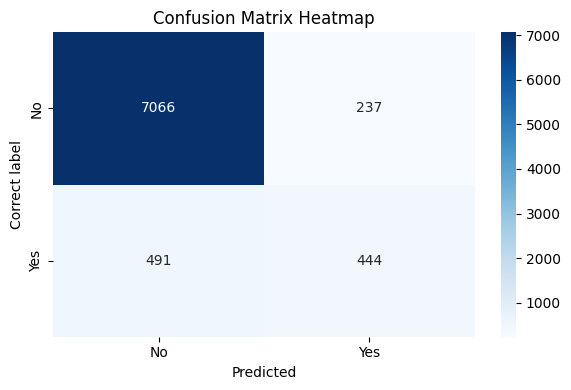

In [12]:
# Measure training time for Random Forest model
start_time = time.time()
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred = clf.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
ari = adjusted_rand_score(y_test, y_pred)
silhouette = silhouette_score(X_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Training Time: {training_time:.4f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Correct label')
plt.tight_layout()
plt.show()

8D SOM

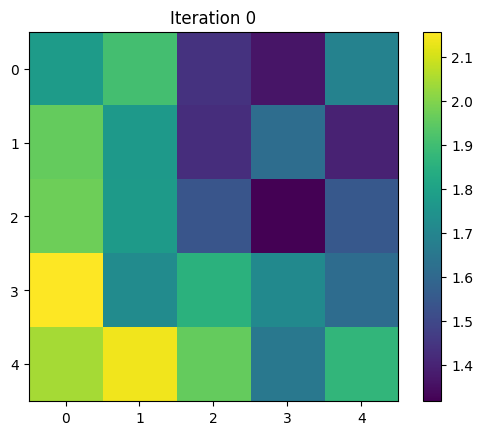

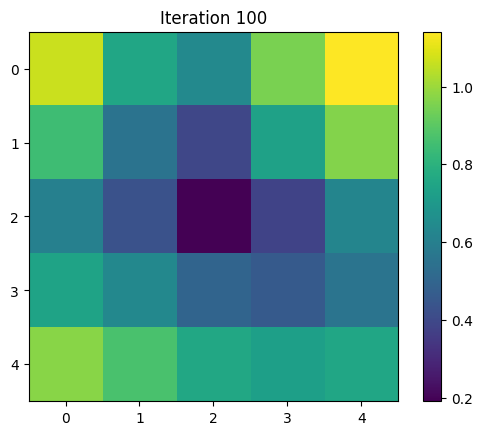

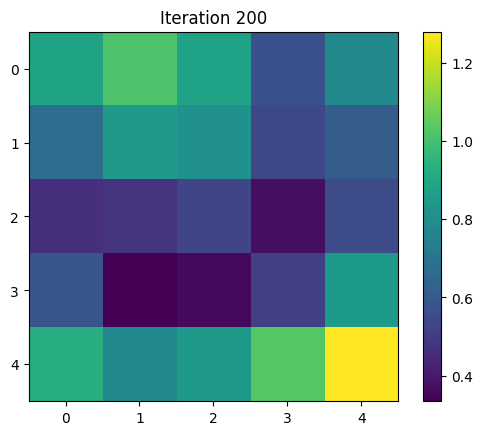

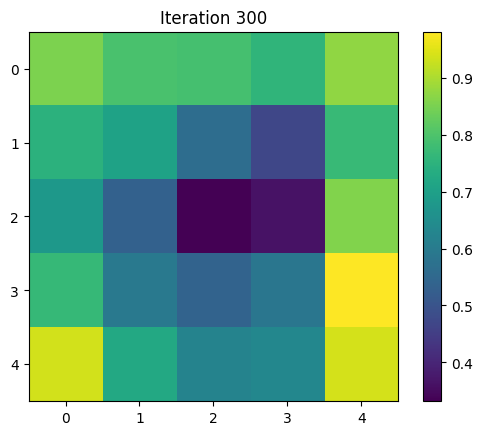

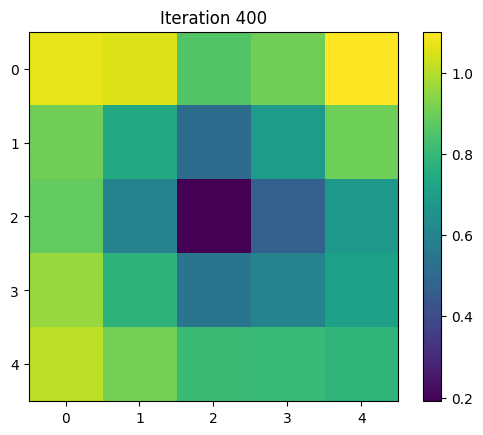

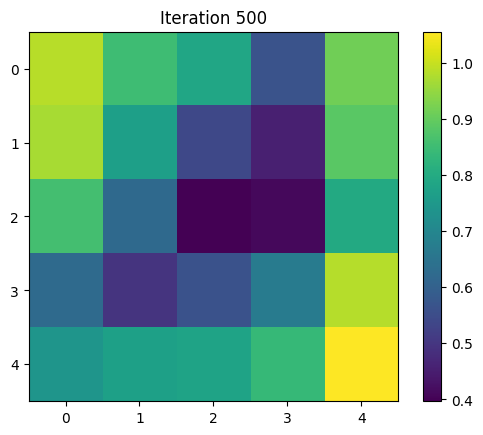

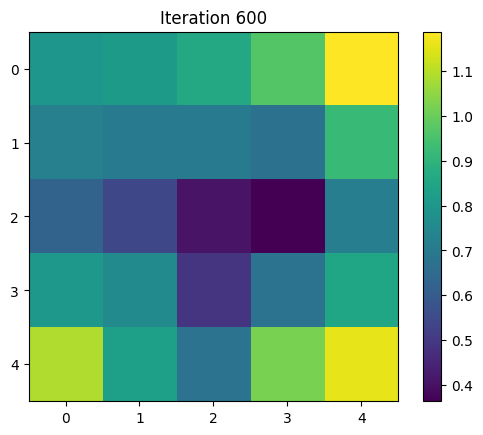

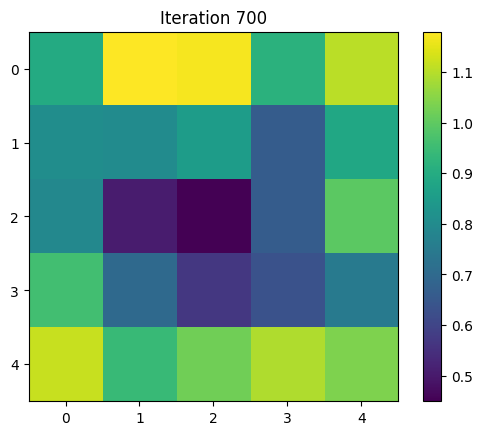

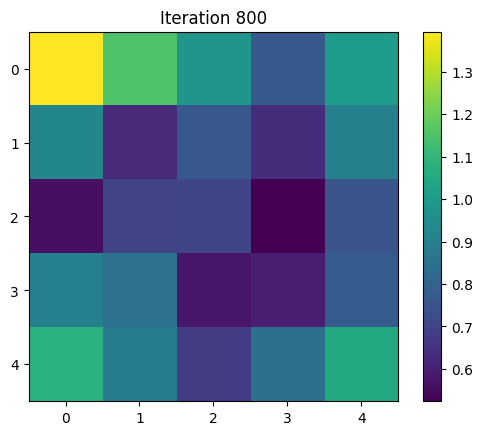

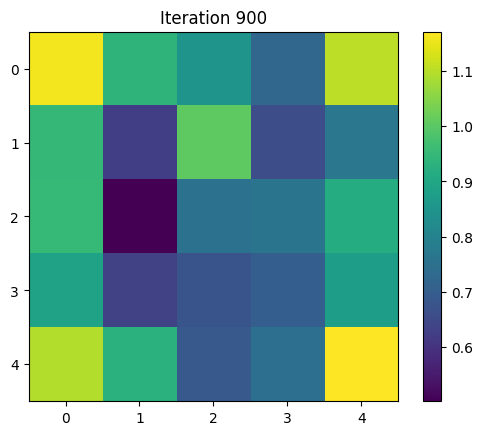

Reduced shape (train, 8D): (32950, 8)
Reduced shape (test, 8D): (8238, 8)


In [13]:
# Extract activation vectors for each sample from the SOM
def bmu_to_activation_vectors(X, som_model, n_features):

    X_activations = []
    for x in X.values:
        # Calculate the distance of all neurons
        distances = np.linalg.norm(som_model.weights - x.reshape(1,1,-1), axis=2)
        flat = distances.flatten()
        # Get the top n closest neurons
        top_n = np.sort(flat)[:n_features]
        X_activations.append(top_n)
    return np.array(X_activations)

# train SOM for 8 dimension
som_8d = SOM(grid_shape=(5,5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_8d.train(X_train)
X_train_8d = bmu_to_activation_vectors(X_train, som_8d, n_features=8)
X_test_8d  = bmu_to_activation_vectors(X_test,  som_8d, n_features=8)

print("Reduced shape (train, 8D):", X_train_8d.shape)
print("Reduced shape (test, 8D):",  X_test_8d.shape)

[SOM with 8 dimensions]
Training Time: 19.1805 seconds
Accuracy: 0.8877
Adjusted Rand Index (ARI): 0.8877
Silhouette Score: 0.5223243381340082


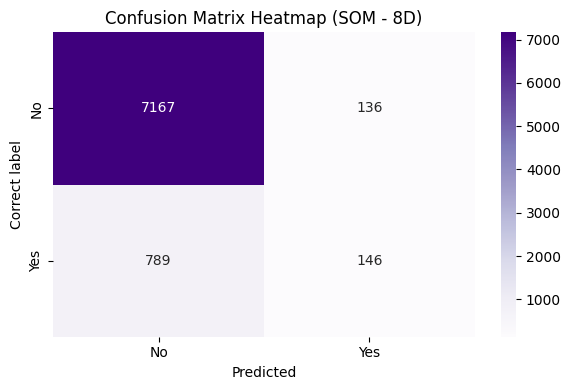

In [14]:
# Measure training time for SOM model with 8 dimensions
start_time = time.time()
clf_8d = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_8d.fit(X_train_8d, y_train)
train_time_8d = time.time() - start_time

y_pred_8d = clf_8d.predict(X_test_8d)

# Compute evaluation metrics
acc_8d = accuracy_score(y_test, y_pred_8d)
ari_8d = adjusted_rand_score(y_test, y_pred_8d)
labels_8d = np.unique(y_pred_8d)
sil_8d = silhouette_score(X_test_8d, y_pred_8d) if len(labels_8d) > 1 else None
cm_8d = confusion_matrix(y_test, y_pred_8d)

print("[SOM with 8 dimensions]")
print(f"Training Time: {train_time_8d:.4f} seconds")
print(f"Accuracy: {acc_8d:.4f}")
print(f"Adjusted Rand Index (ARI): {acc_8d:.4f}")
print(f"Silhouette Score: {sil_8d if sil_8d is not None else 'N/A'}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_8d, annot=True, fmt='d', cmap='Purples', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix Heatmap (SOM - 8D)')
plt.xlabel('Predicted')
plt.ylabel('Correct label')
plt.tight_layout()
plt.show()

4D SOM

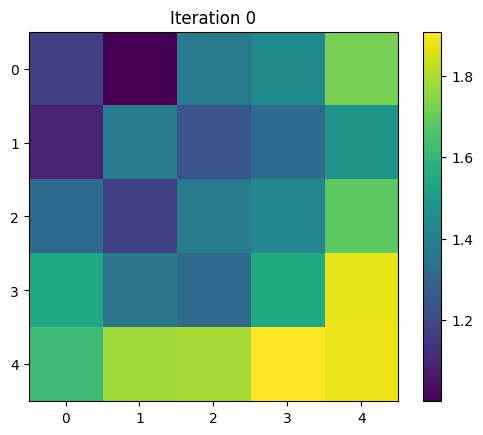

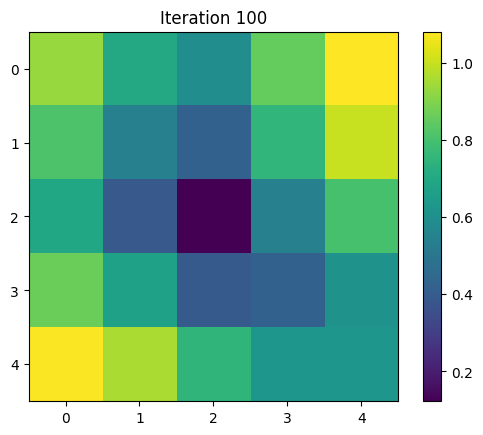

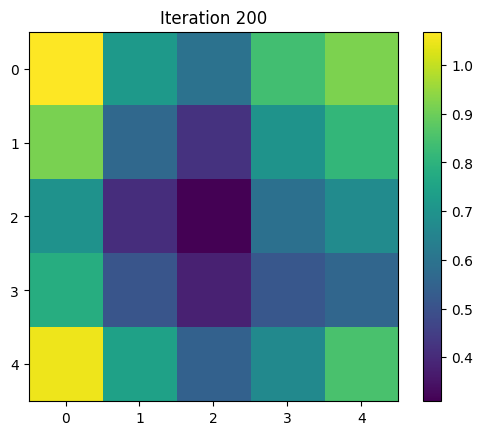

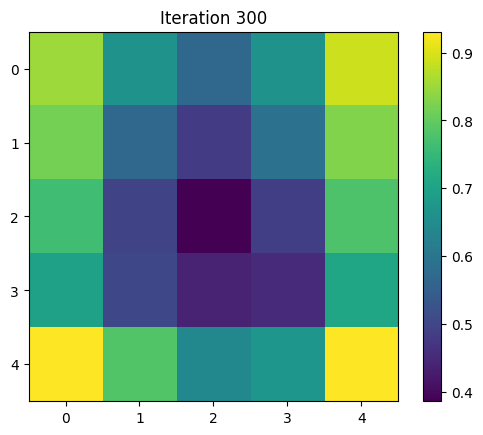

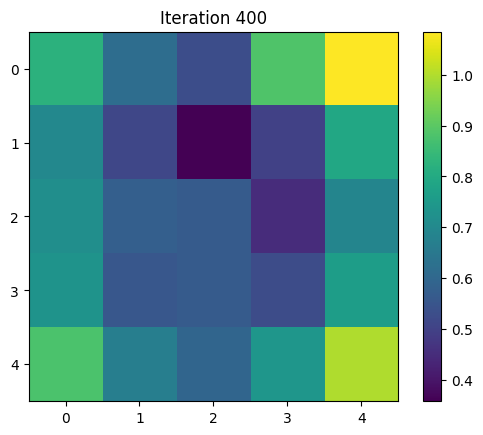

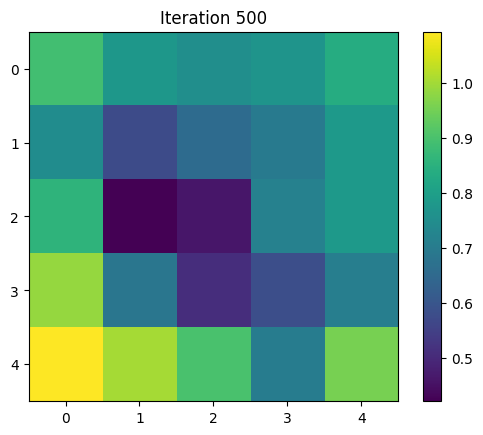

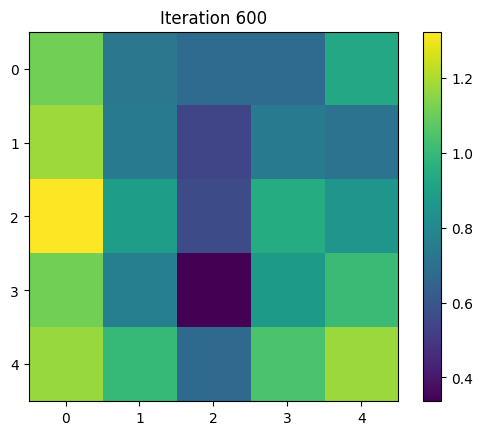

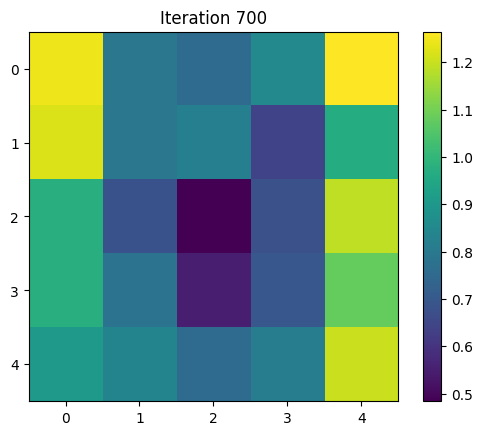

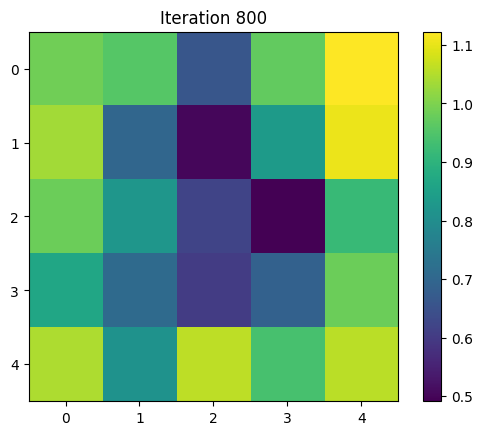

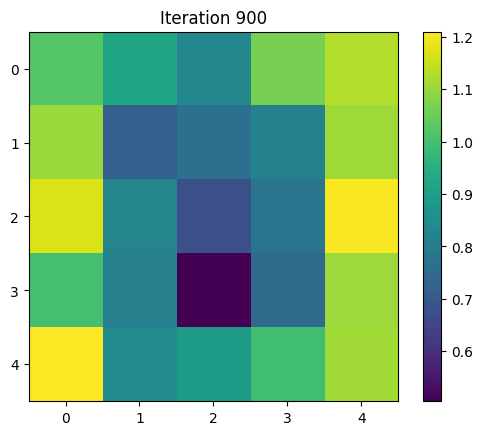

Reduced shape (train, 4D): (32950, 4)
Reduced shape (test, 4D): (8238, 4)


In [15]:
# train SOM for 4 dimension
som_4d = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_4d.train(X_train)
X_train_4d = bmu_to_activation_vectors(X_train, som_4d, n_features=4)
X_test_4d  = bmu_to_activation_vectors(X_test,  som_4d, n_features=4)

print("Reduced shape (train, 4D):", X_train_4d.shape)
print("Reduced shape (test, 4D):",  X_test_4d.shape)

[SOM with 4 dimensions]
Training Time: 21.6311 s
Accuracy: 0.8866
ARI:      0.1500
Silhouette: 0.4918652146844992


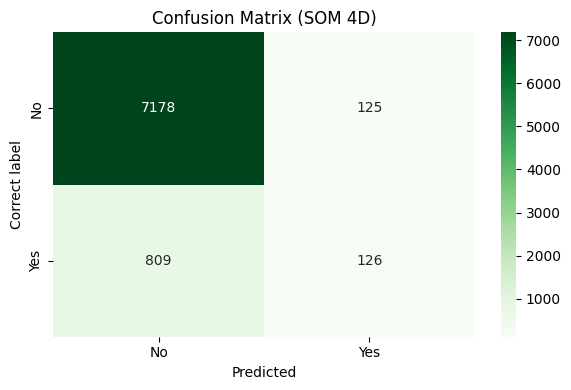

In [16]:
# Measure training time for SOM model with 4 dimensions
start = time.time()
clf_4d = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_4d.fit(X_train_4d, y_train)
train_time_4d = time.time() - start

y_pred_4d = clf_4d.predict(X_test_4d)

# Compute evaluation metrics
acc_4d = accuracy_score(y_test, y_pred_4d)
ari_4d = adjusted_rand_score(y_test, y_pred_4d)
labels_4d = np.unique(y_pred_4d)
sil_4d = silhouette_score(X_test_4d, y_pred_4d) if len(labels_4d) > 1 else None
cm_4d  = confusion_matrix(y_test, y_pred_4d)

print("[SOM with 4 dimensions]")
print(f"Training Time: {train_time_4d:.4f} s")
print(f"Accuracy: {acc_4d:.4f}")
print(f"ARI: {ari_4d:.4f}")
print(f"Silhouette: {sil_4d if sil_4d is not None else 'N/A'}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_4d, annot=True, fmt='d', cmap='Greens', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.title('Confusion Matrix (SOM 4D)')
plt.xlabel('Predicted')
plt.ylabel('Correct label')
plt.tight_layout()
plt.show()

2D SOM

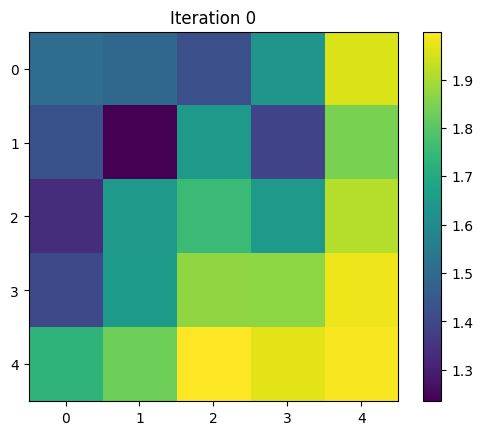

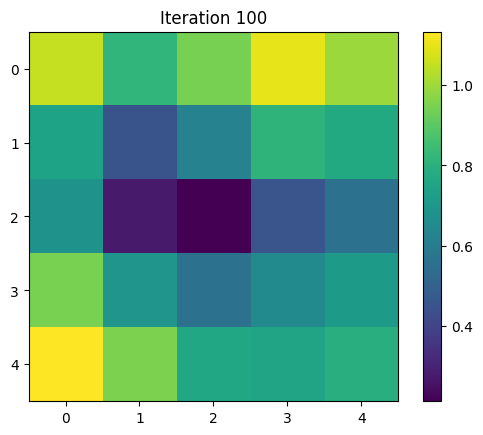

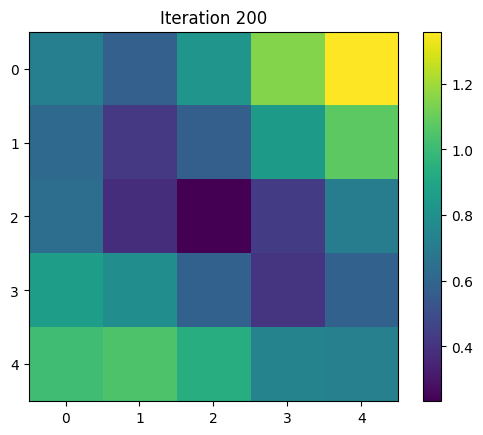

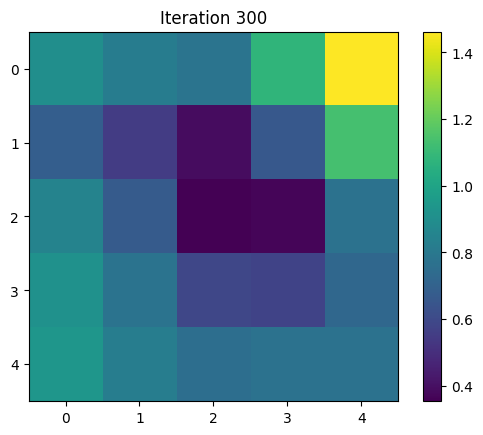

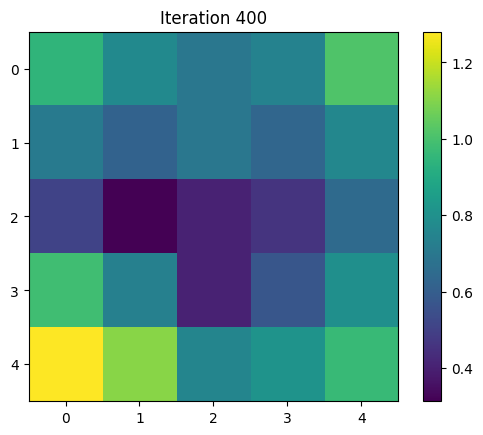

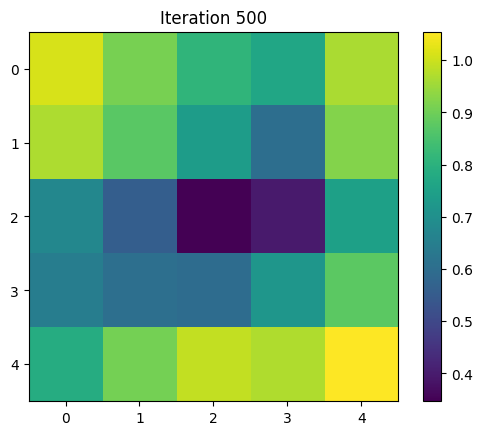

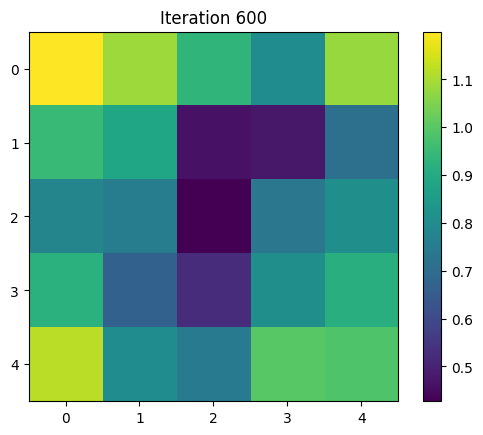

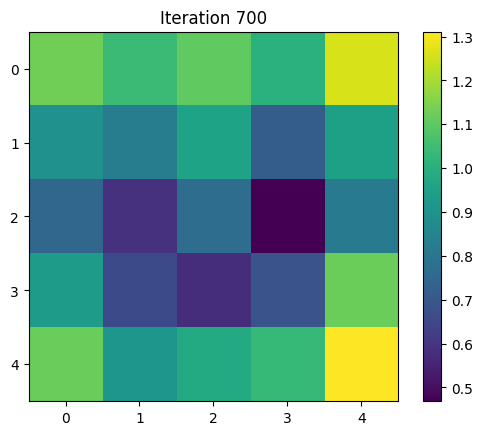

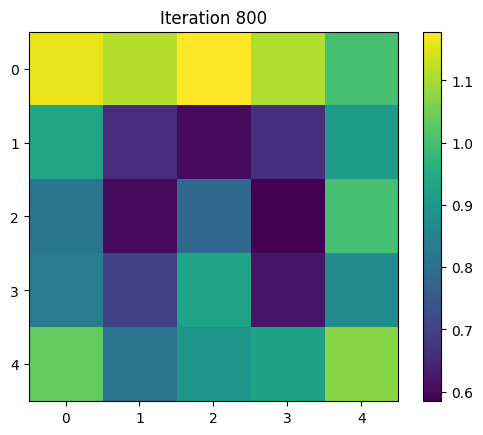

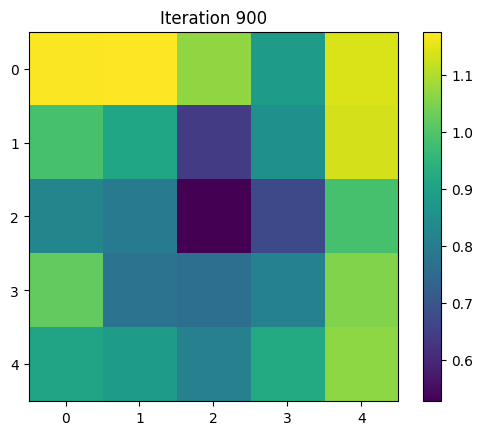

Reduced shape (train, 2D): (32950, 2)
Reduced shape (test, 2D): (8238, 2)


In [17]:
# train SOM for 2 dimension
som_2d = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_2d.train(X_train)
X_train_2d = bmu_to_activation_vectors(X_train, som_2d, n_features=2)
X_test_2d  = bmu_to_activation_vectors(X_test,  som_2d, n_features=2)

print("Reduced shape (train, 2D):", X_train_2d.shape)
print("Reduced shape (test, 2D):",  X_test_2d.shape)

[SOM with 2 dimensions]
Training Time: 13.5843 s
Accuracy: 0.8819
ARI: 0.1499
Silhouette: 0.44640699260924427


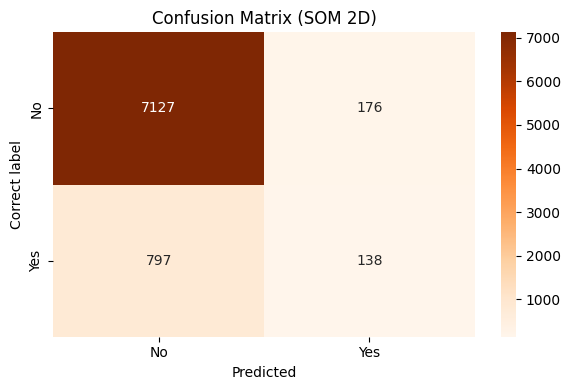

In [18]:
# Measure training time for SOM model with 2 dimensions
start = time.time()
clf_2d = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_2d.fit(X_train_2d, y_train)
train_time_2d = time.time() - start

y_pred_2d = clf_2d.predict(X_test_2d)

# Compute evaluation metrics
acc_2d = accuracy_score(y_test, y_pred_2d)
ari_2d = adjusted_rand_score(y_test, y_pred_2d)
labels_2d = np.unique(y_pred_2d)
sil_2d = silhouette_score(X_test_2d, y_pred_2d) if len(labels_2d) > 1 else None
cm_2d  = confusion_matrix(y_test, y_pred_2d)

print("[SOM with 2 dimensions]")
print(f"Training Time: {train_time_2d:.4f} s")
print(f"Accuracy: {acc_2d:.4f}")
print(f"ARI: {ari_2d:.4f}")
print(f"Silhouette: {sil_2d if sil_2d is not None else 'N/A'}")

# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm_2d, annot=True, fmt='d', cmap='Oranges', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.title('Confusion Matrix (SOM 2D)')
plt.xlabel('Predicted')
plt.ylabel('Correct label')
plt.tight_layout()
plt.show()

# Part 2:

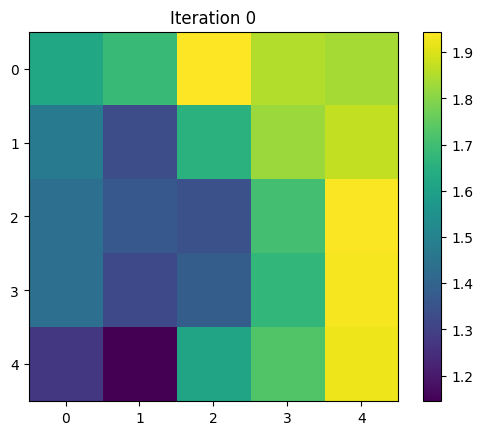

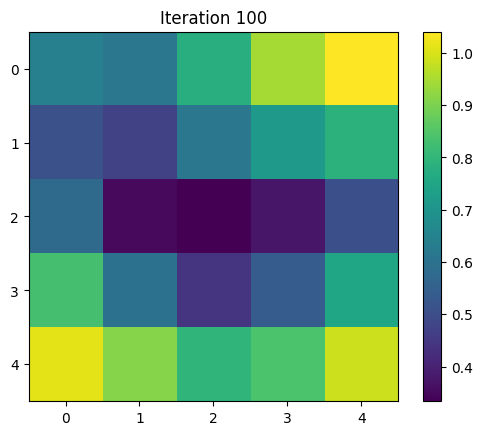

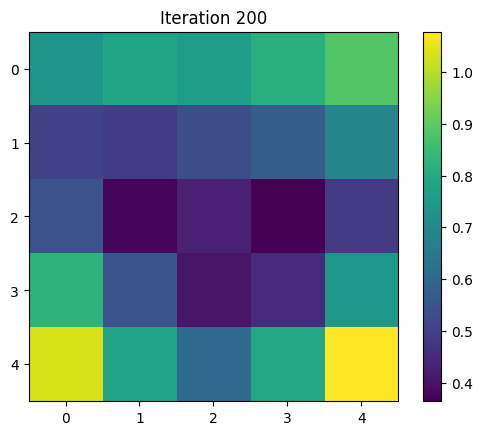

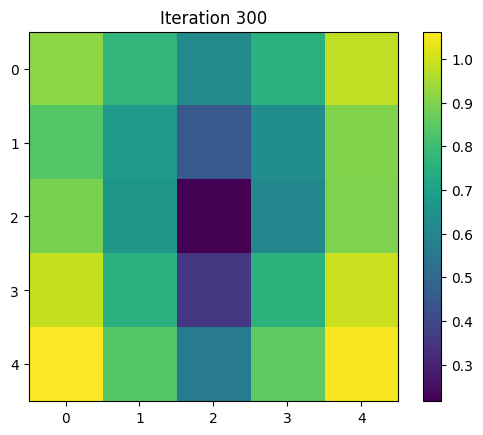

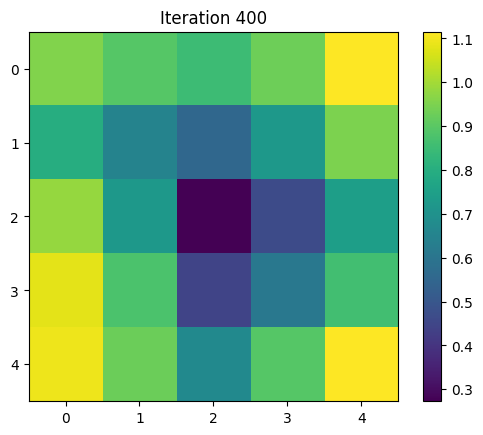

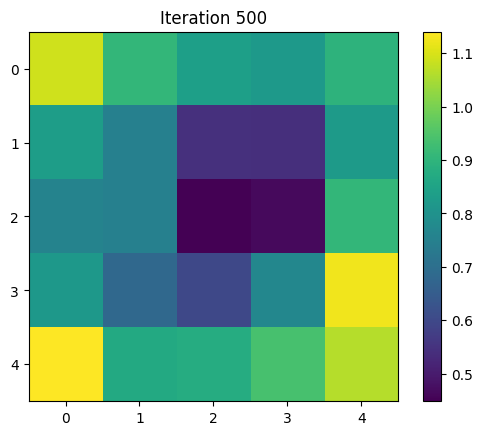

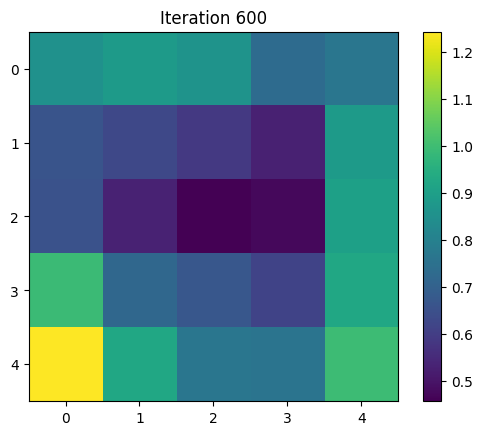

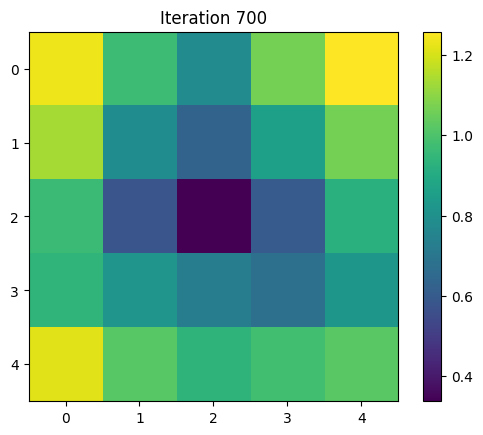

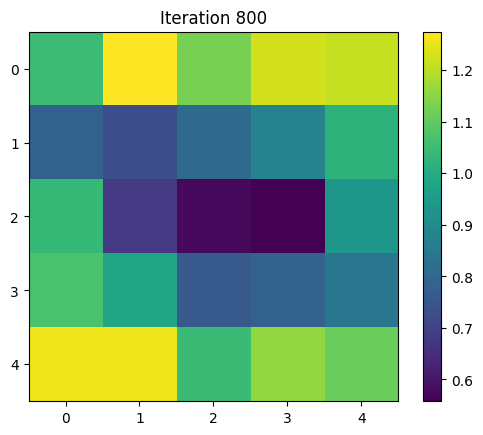

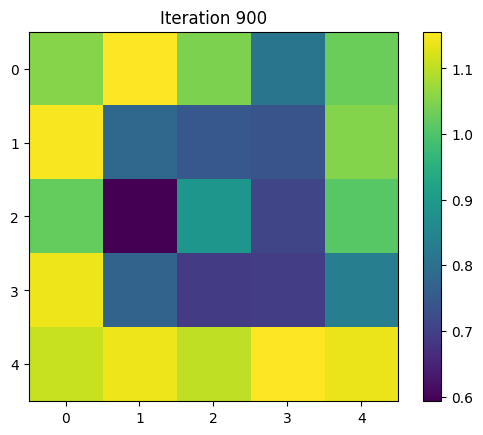

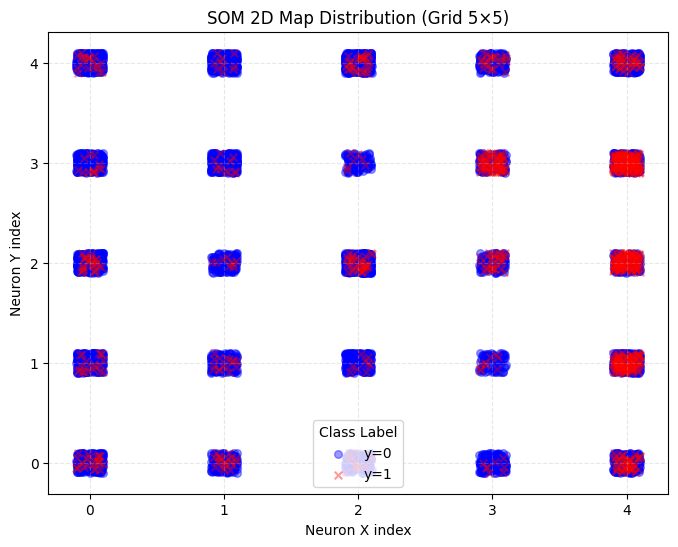

In [20]:
som_map = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_map.train(X_train)

# Find BMUs for X_test
bmu_test = som_map.transform(X_test)  # shape = (n_samples, 2)
xs, ys = bmu_test[:,0], bmu_test[:,1]

# Add small random jitter to positions
jitter = 0.1
xs_j = xs + np.random.uniform(-jitter, jitter, size=xs.shape)   
ys_j = ys + np.random.uniform(-jitter, jitter, size=ys.shape)

# Plot SOM map
plt.figure(figsize=(8,6))
for label, color, marker in zip([0,1], ['blue','red'], ['o','x']):
    idx = (y_test.values == label)
    plt.scatter(xs_j[idx], ys_j[idx], c=color, marker=marker,
                label=f"y={label}", alpha=0.4, s=30)

plt.xticks(range(5))
plt.yticks(range(5))
plt.grid(True, linestyle='--', alpha=0.3)
plt.title("SOM 2D Map Distribution (Grid 5×5)")
plt.xlabel("Neuron X index")
plt.ylabel("Neuron Y index")
plt.legend(title="Class Label")
plt.show()

# Part 3:

Grid Size: 5x5

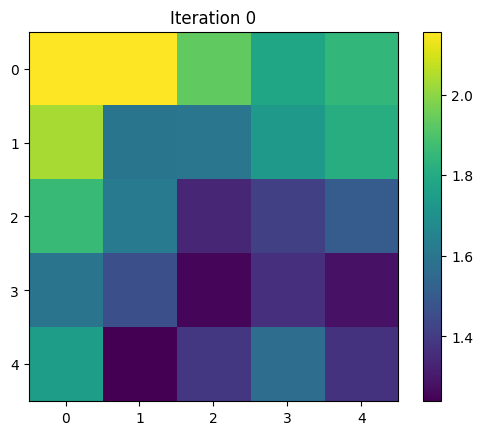

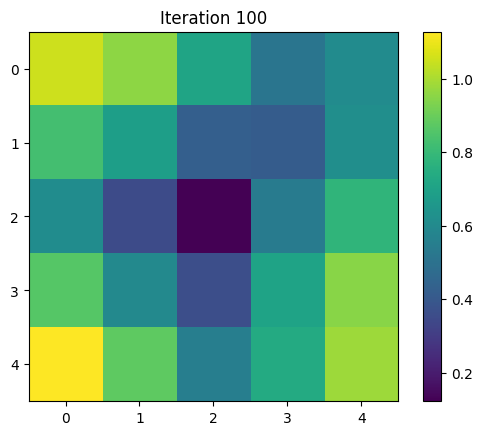

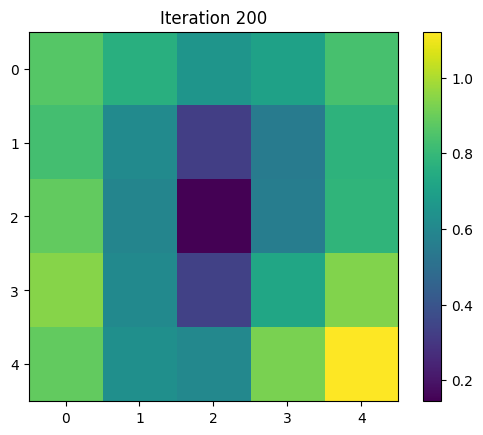

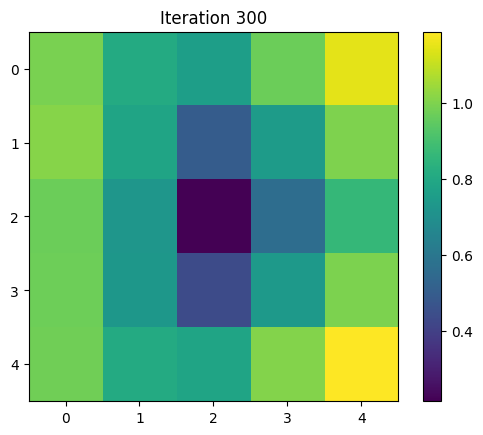

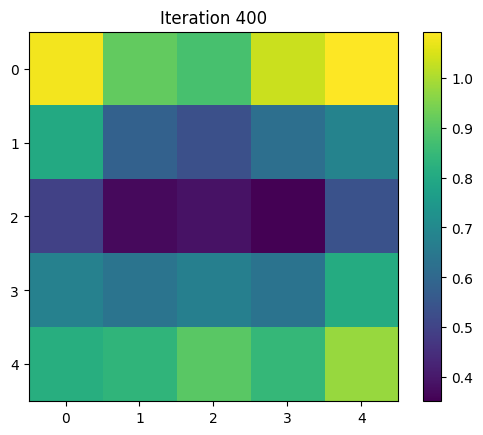

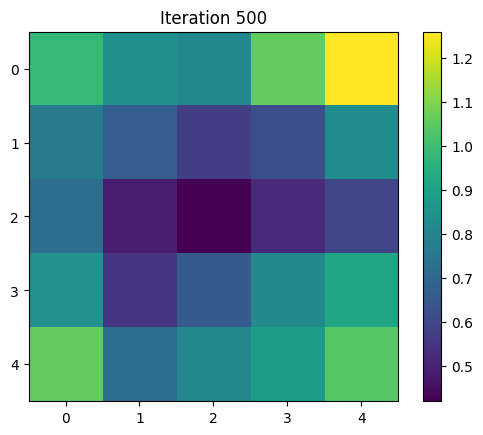

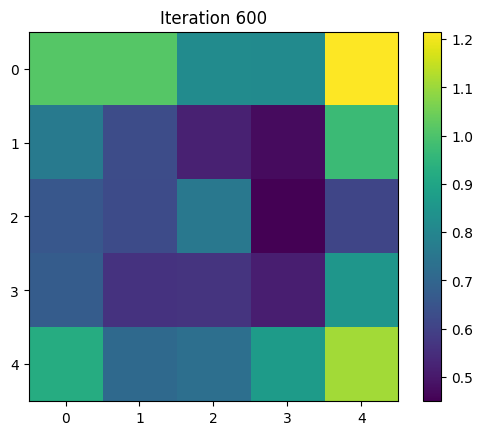

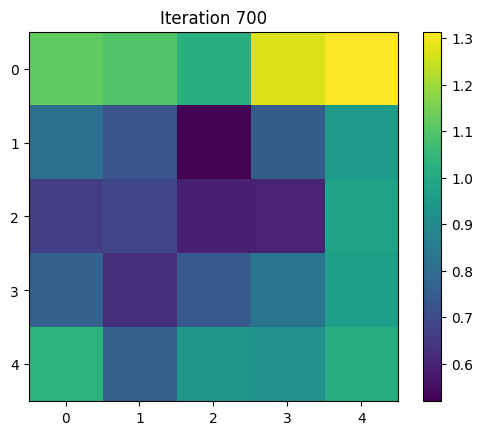

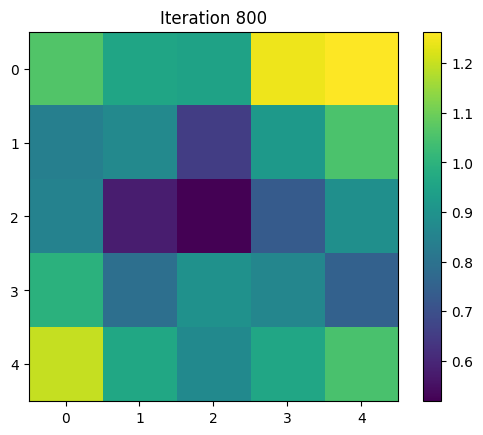

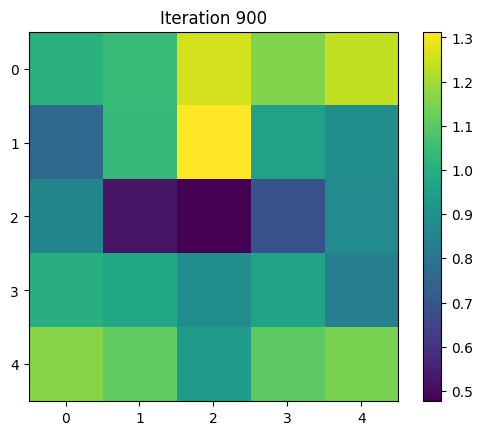

[Grid 5x5]
Accuracy: 0.8858
ARI:      0.1787
Silhouette: 0.5420
Training Time: 18.1099 seconds


In [21]:
# SOM Grid Size: 5x5
som_5 = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_5.train(X_train)

X_train_5 = bmu_to_activation_vectors(X_train, som_5, n_features=8)
X_test_5 = bmu_to_activation_vectors(X_test, som_5, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_5 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_5.fit(X_train_5, y_train)
train_time_5 = time.time() - start

y_pred_5 = clf_5.predict(X_test_5)

print("[Grid 5x5]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_5):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_5):.4f}")
print(f"Silhouette: {silhouette_score(X_test_5, y_pred_5):.4f}")
print(f"Training Time: {train_time_5:.4f} seconds")

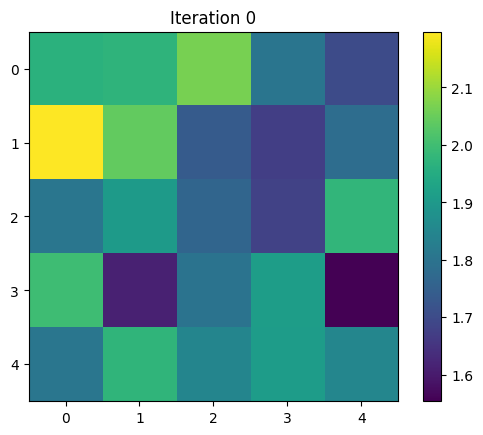

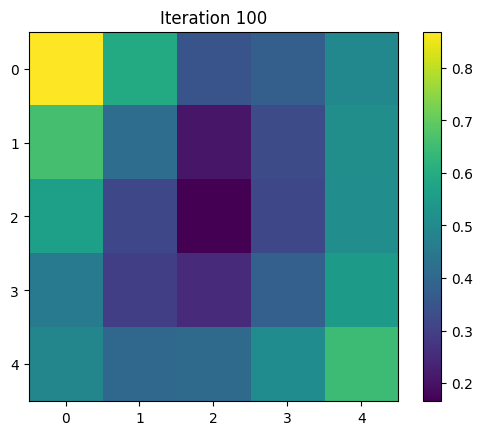

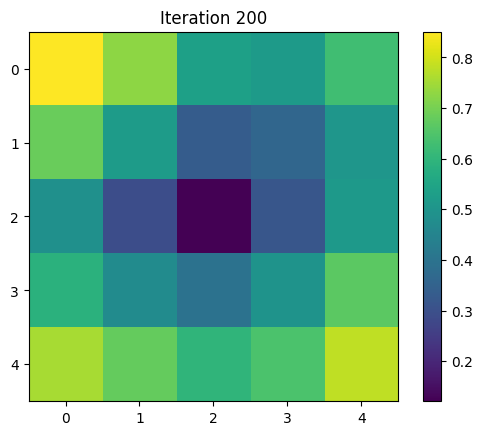

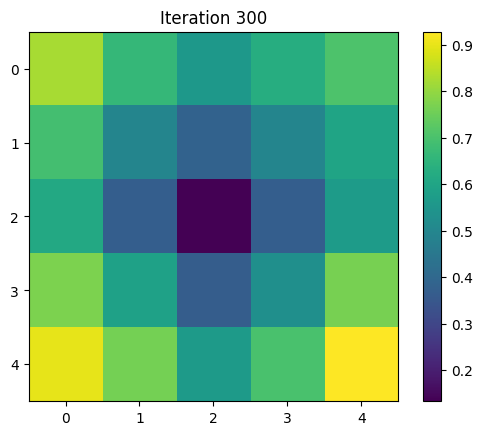

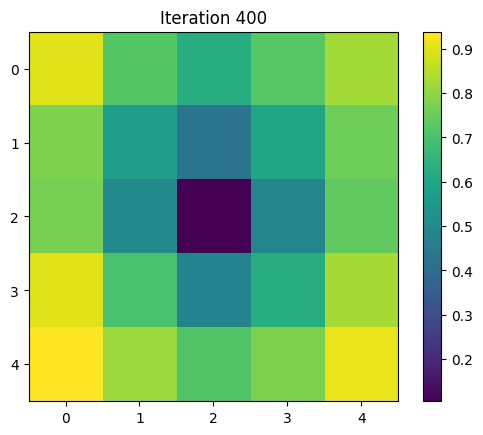

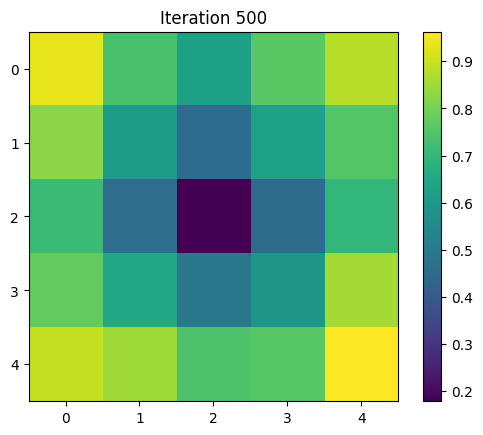

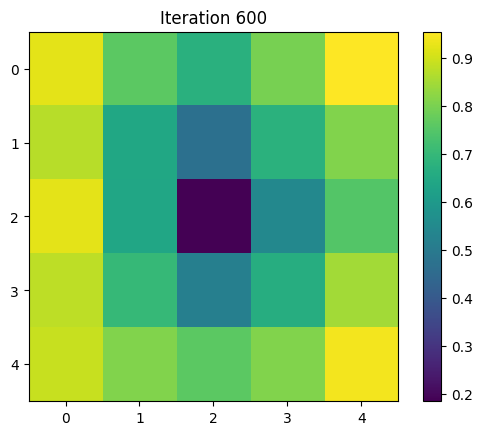

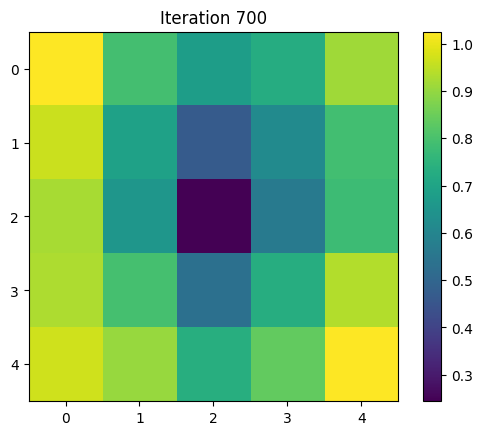

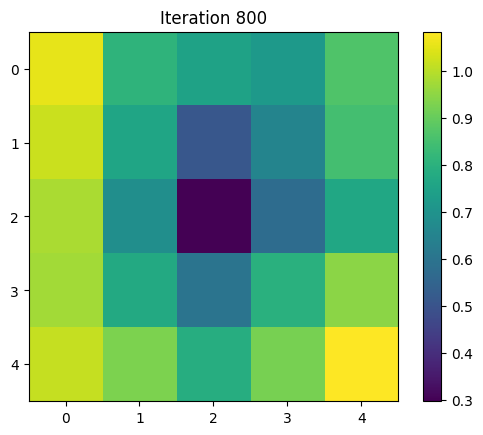

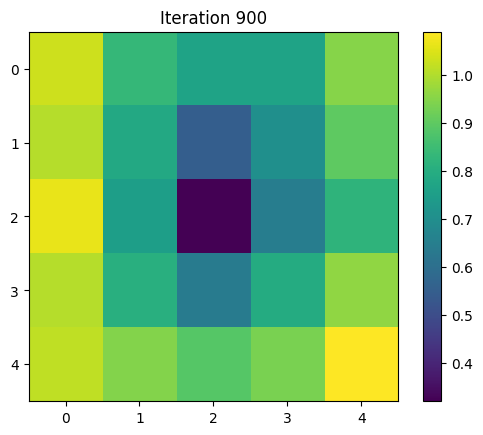

[Grid 5x5]
Accuracy: 0.8877
ARI:      0.1847
Silhouette: 0.5014
Training Time: 19.7897 seconds


In [22]:
# SOM Grid Size: 5x5
som_5 = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.1, radius=2.0, max_iter=1000)
som_5.train(X_train)

X_train_5 = bmu_to_activation_vectors(X_train, som_5, n_features=8)
X_test_5 = bmu_to_activation_vectors(X_test, som_5, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_5 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_5.fit(X_train_5, y_train)
train_time_5 = time.time() - start

y_pred_5 = clf_5.predict(X_test_5)

print("[Grid 5x5]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_5):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_5):.4f}")
print(f"Silhouette: {silhouette_score(X_test_5, y_pred_5):.4f}")
print(f"Training Time: {train_time_5:.4f} seconds")

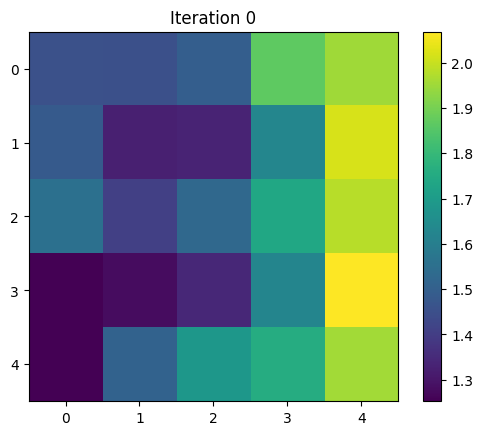

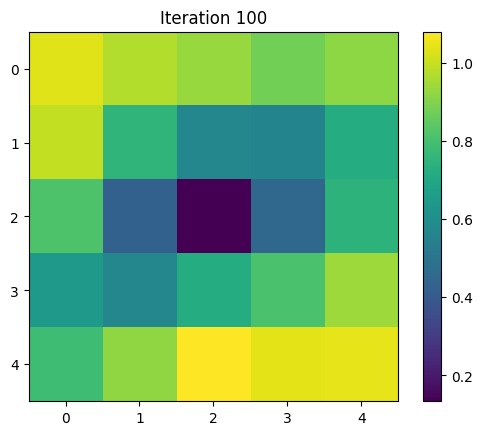

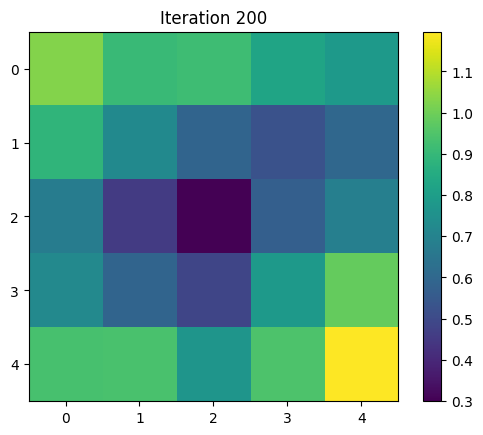

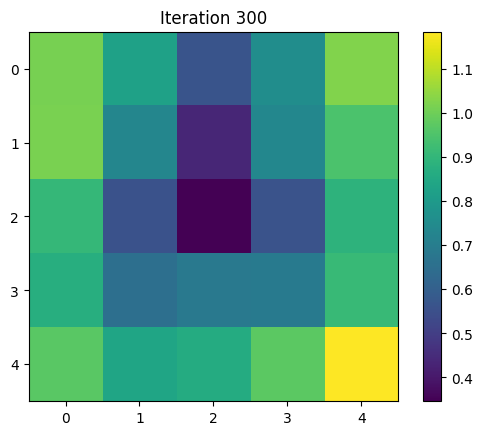

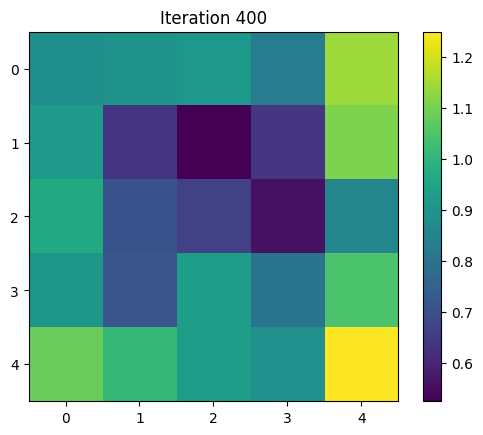

[Grid 5x5]
Accuracy: 0.8869
ARI:      0.1565
Silhouette: 0.3407
Training Time: 21.1132 seconds


In [23]:
# SOM Grid Size: 5x5
som_5 = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=500)
som_5.train(X_train)

X_train_5 = bmu_to_activation_vectors(X_train, som_5, n_features=8)
X_test_5 = bmu_to_activation_vectors(X_test, som_5, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_5 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_5.fit(X_train_5, y_train)
train_time_5 = time.time() - start

y_pred_5 = clf_5.predict(X_test_5)

print("[Grid 5x5]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_5):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_5):.4f}")
print(f"Silhouette: {silhouette_score(X_test_5, y_pred_5):.4f}")
print(f"Training Time: {train_time_5:.4f} seconds")

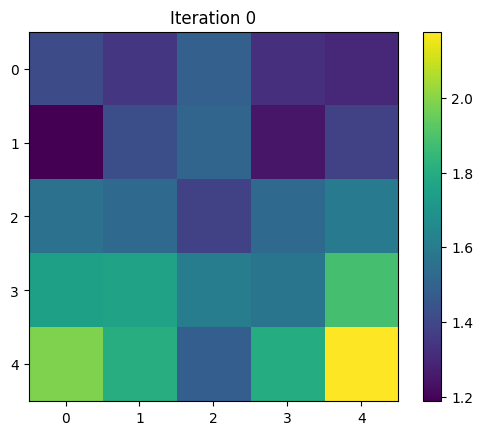

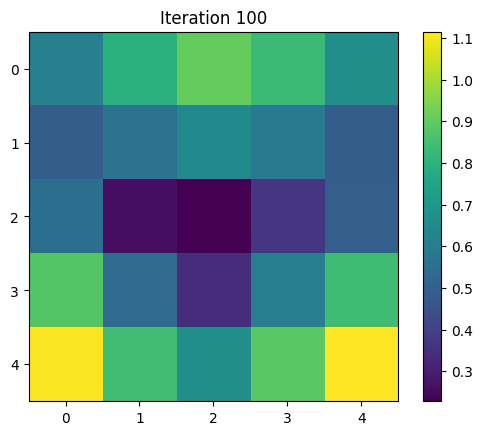

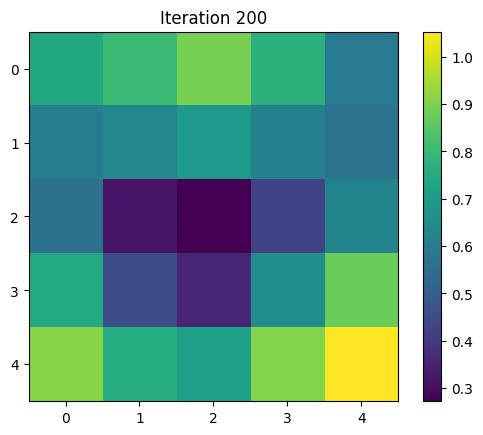

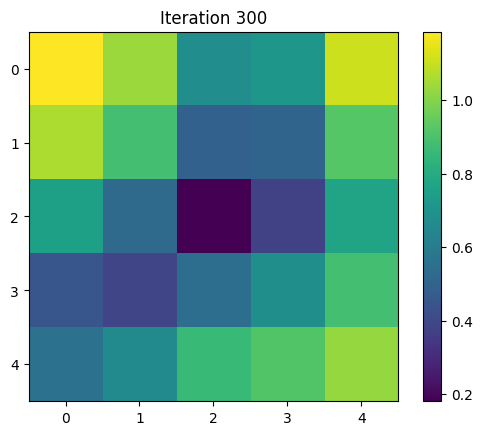

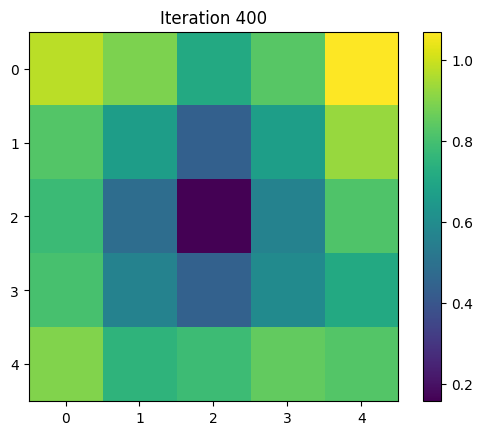

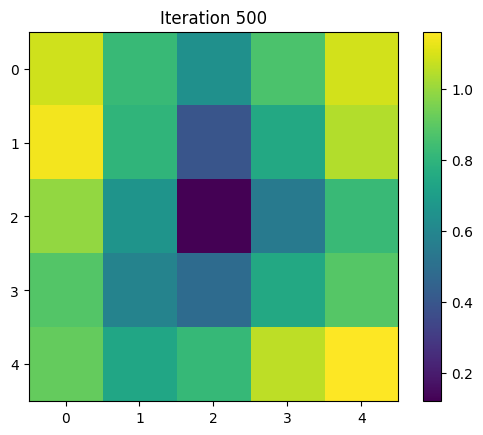

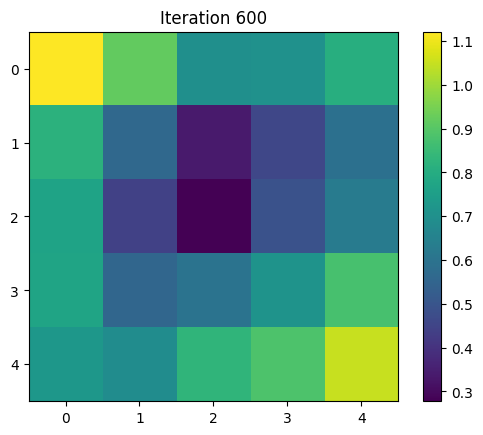

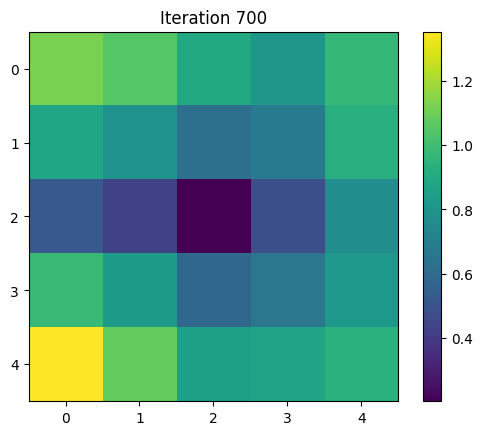

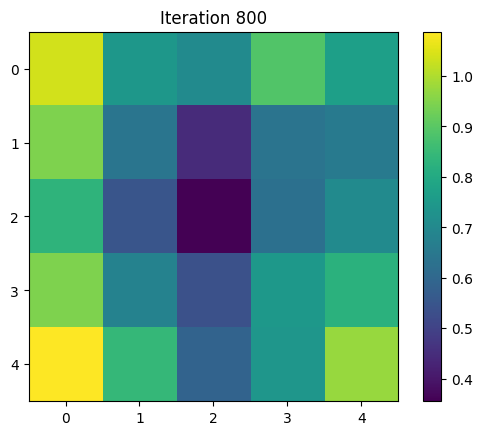

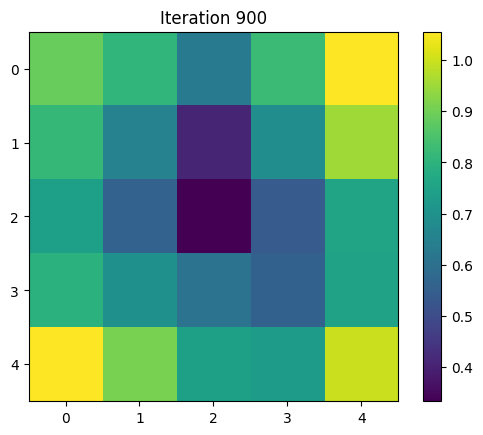

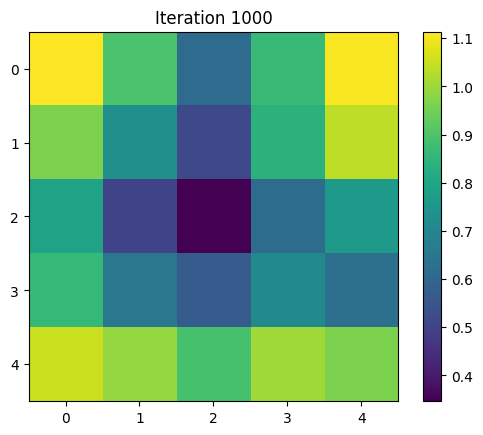

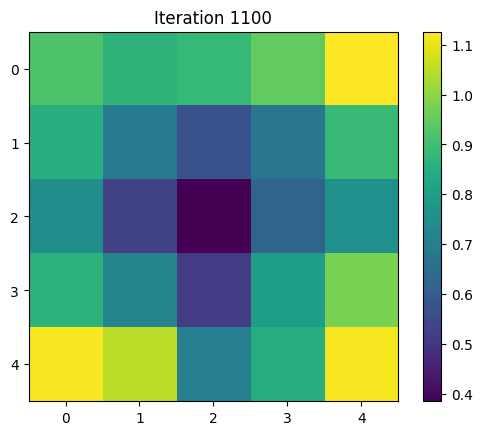

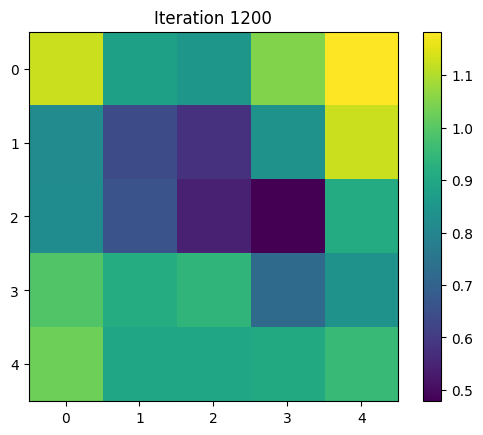

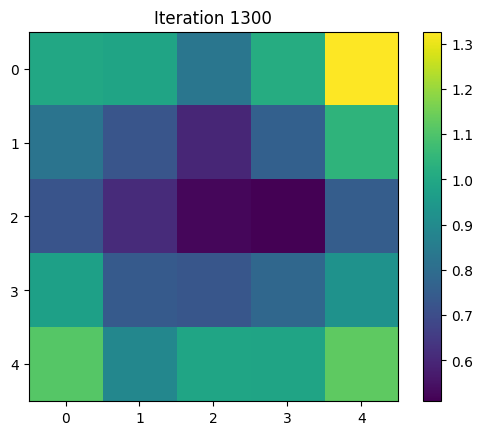

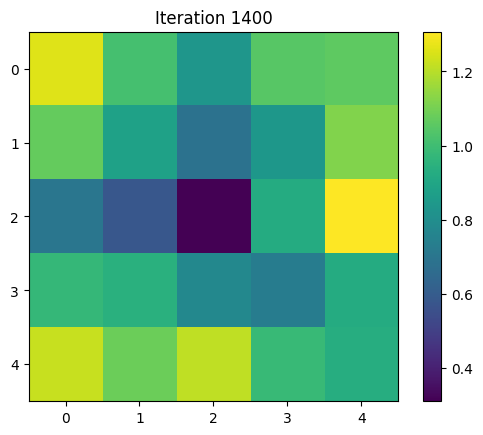

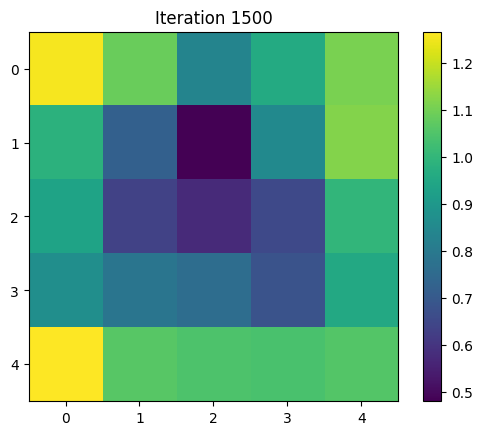

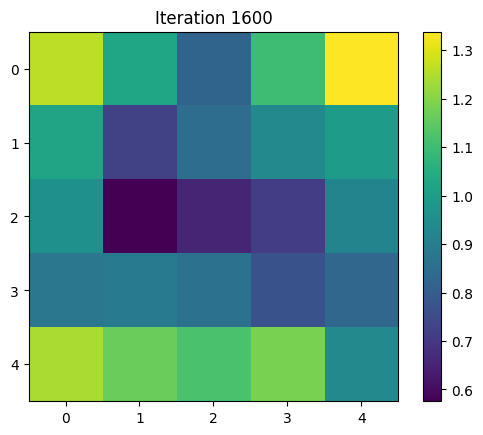

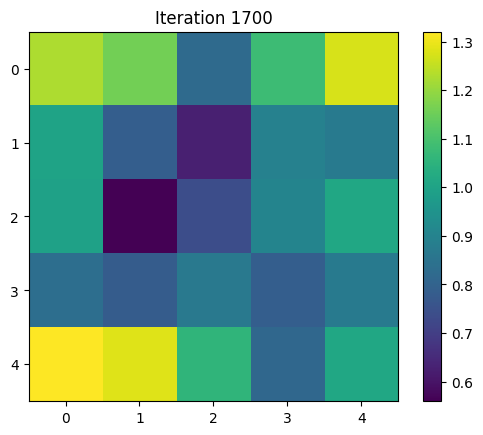

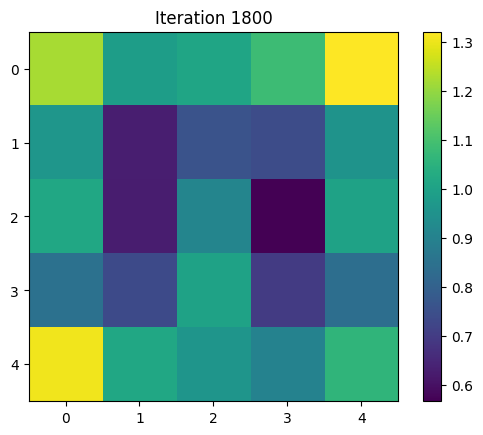

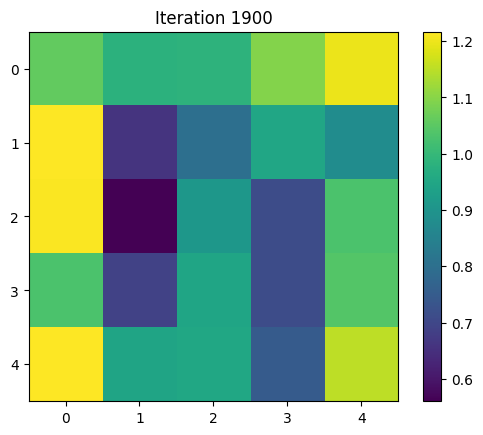

[Grid 5x5]
Accuracy: 0.8864
ARI:      0.1684
Silhouette: 0.5009
Training Time: 23.6451 seconds


In [24]:
# SOM Grid Size: 5x5
som_5 = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=2000)
som_5.train(X_train)

X_train_5 = bmu_to_activation_vectors(X_train, som_5, n_features=8)
X_test_5 = bmu_to_activation_vectors(X_test, som_5, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_5 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_5.fit(X_train_5, y_train)
train_time_5 = time.time() - start

y_pred_5 = clf_5.predict(X_test_5)

print("[Grid 5x5]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_5):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_5):.4f}")
print(f"Silhouette: {silhouette_score(X_test_5, y_pred_5):.4f}")
print(f"Training Time: {train_time_5:.4f} seconds")

Grid Size: 10x10

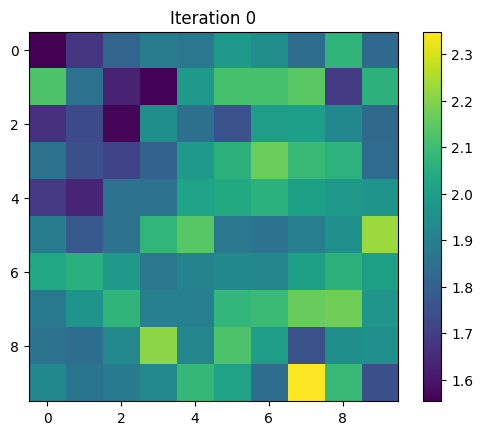

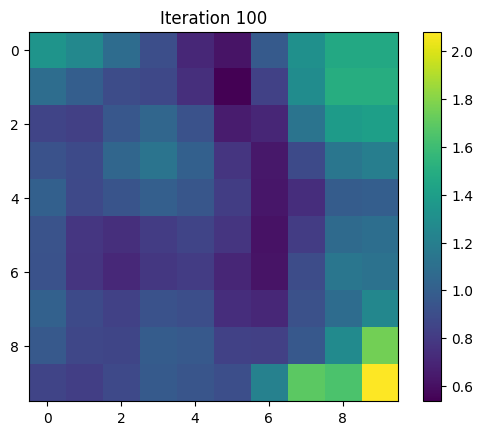

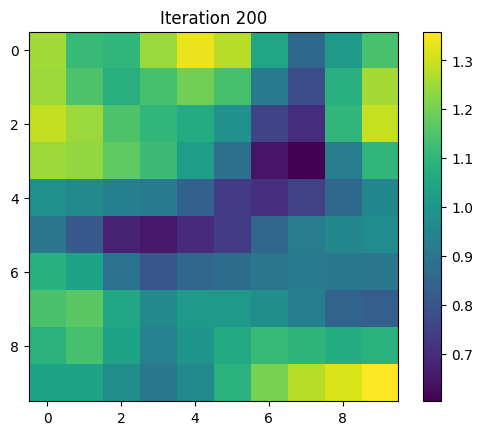

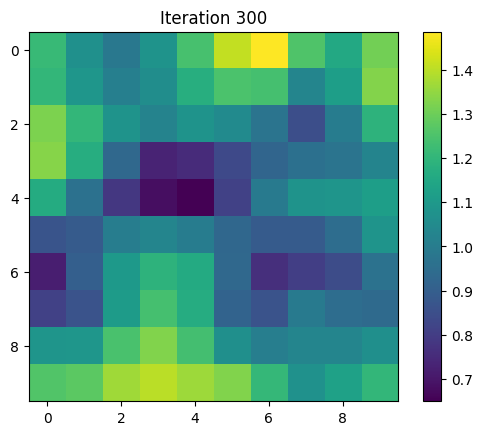

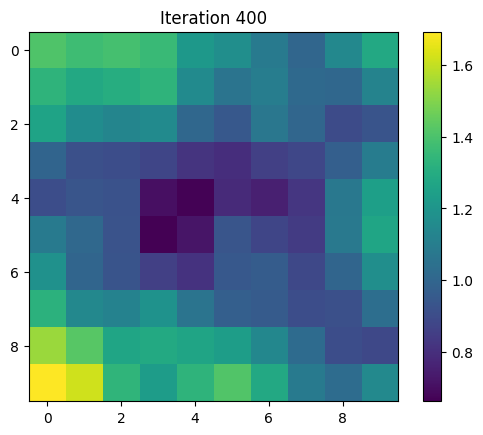

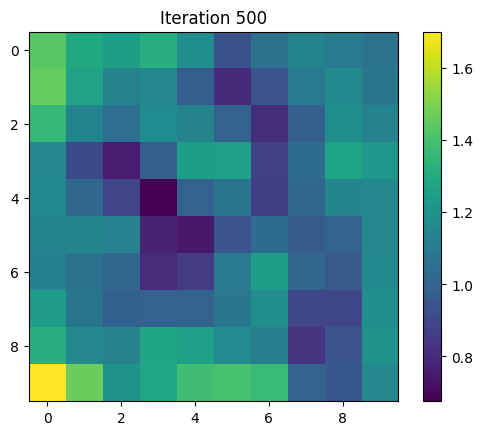

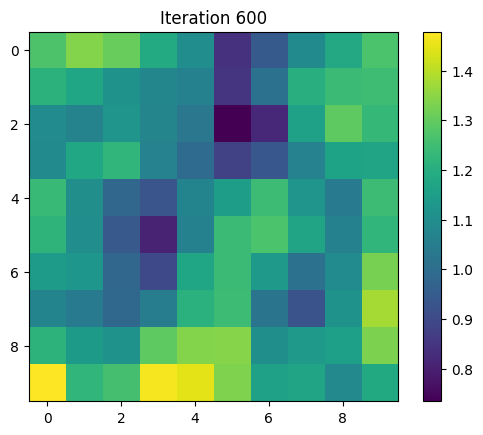

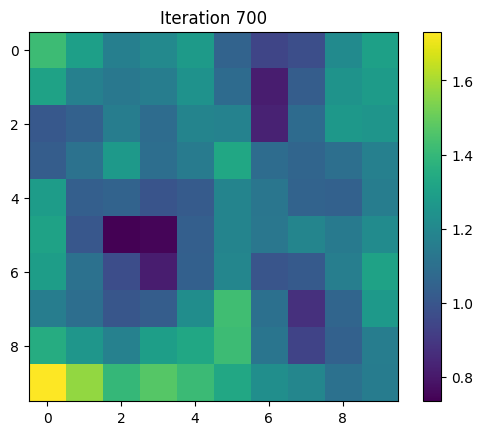

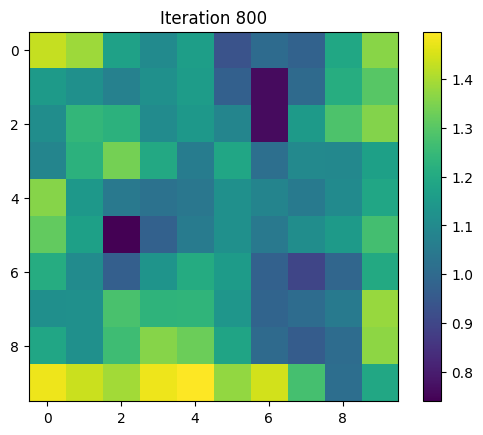

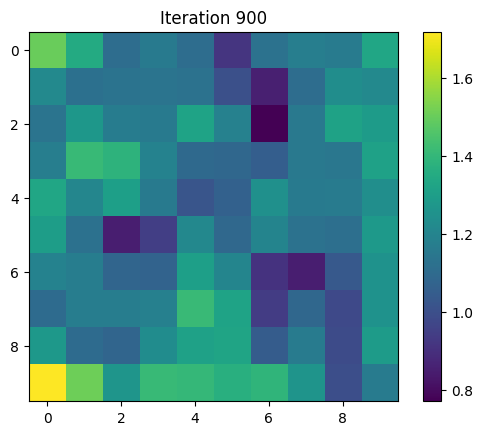

[Grid 10x10]
Accuracy: 0.8874
ARI: 0.1615
Silhouette: 0.4136
Training Time: 22.0060 seconds


In [25]:
# SOM Grid Size: 10x10
som_10 = SOM(grid_shape=(10, 10), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_10.train(X_train)

X_train_10 = bmu_to_activation_vectors(X_train, som_10, n_features=8)
X_test_10 = bmu_to_activation_vectors(X_test, som_10, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_10 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_10.fit(X_train_10, y_train)
train_time_10 = time.time() - start

y_pred_10 = clf_10.predict(X_test_10)

print("[Grid 10x10]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_10):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_10):.4f}")
print(f"Silhouette: {silhouette_score(X_test_10, y_pred_10):.4f}")
print(f"Training Time: {train_time_10:.4f} seconds")

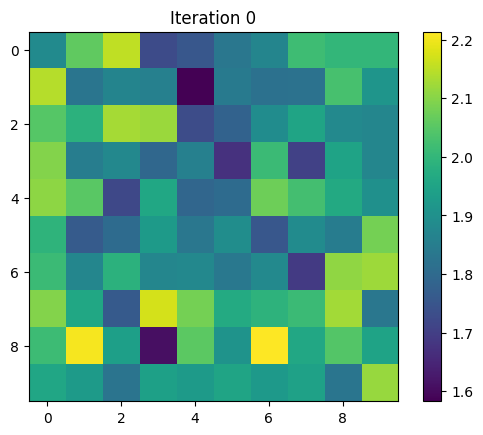

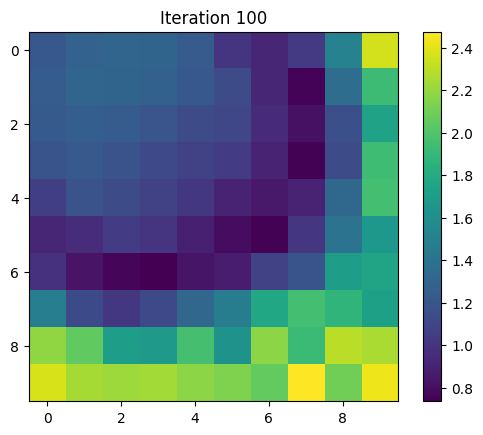

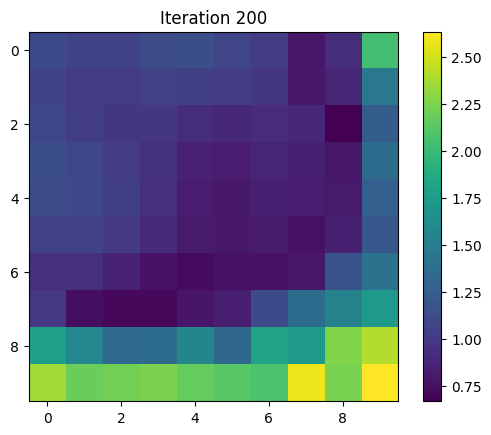

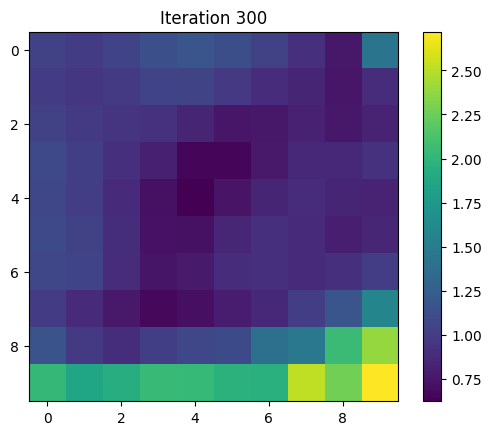

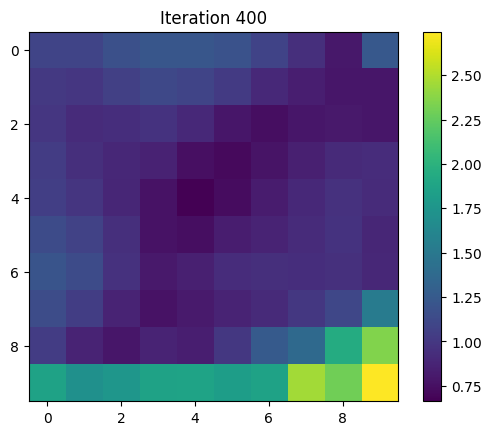

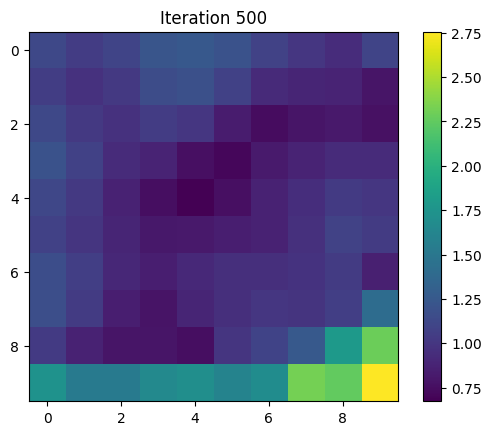

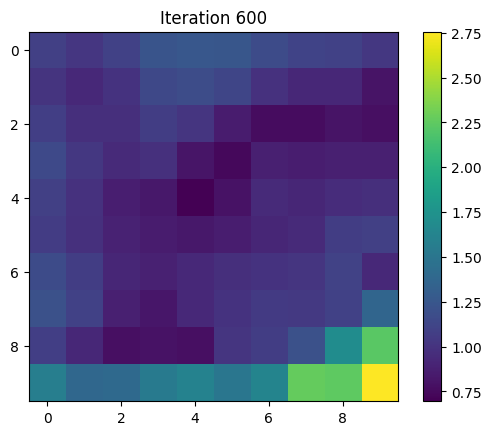

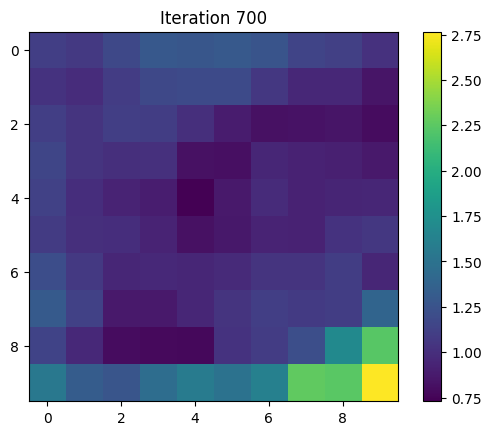

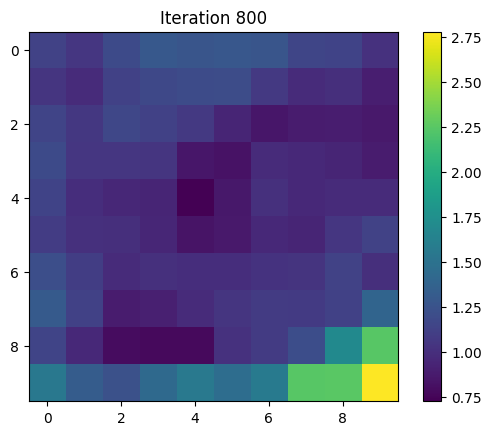

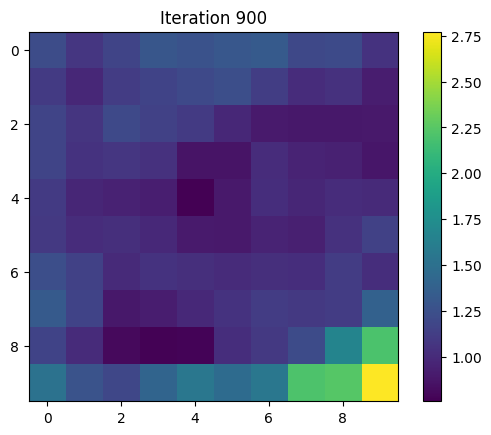

[Grid 10x10]
Accuracy: 0.8837
ARI: 0.1147
Silhouette: 0.3679
Training Time: 20.3869 seconds


In [26]:
# SOM Grid Size: 10x10
som_10 = SOM(grid_shape=(10, 10), input_dim=X_train.shape[1], learning_rate=0.1, radius=2.0, max_iter=1000)
som_10.train(X_train)

X_train_10 = bmu_to_activation_vectors(X_train, som_10, n_features=8)
X_test_10 = bmu_to_activation_vectors(X_test, som_10, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_10 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_10.fit(X_train_10, y_train)
train_time_10 = time.time() - start

y_pred_10 = clf_10.predict(X_test_10)

print("[Grid 10x10]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_10):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_10):.4f}")
print(f"Silhouette: {silhouette_score(X_test_10, y_pred_10):.4f}")
print(f"Training Time: {train_time_10:.4f} seconds")

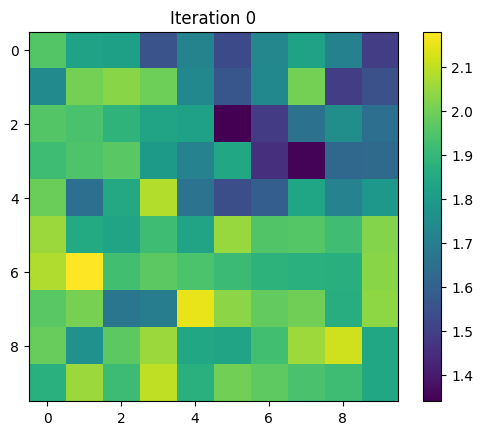

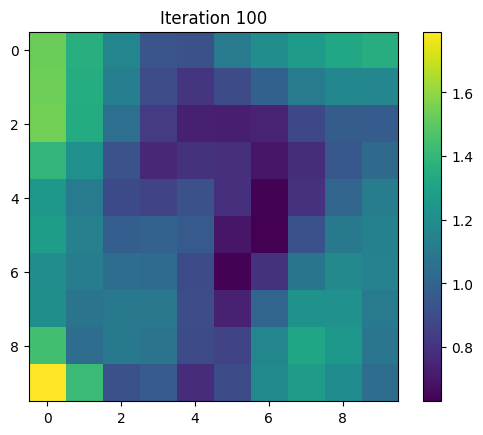

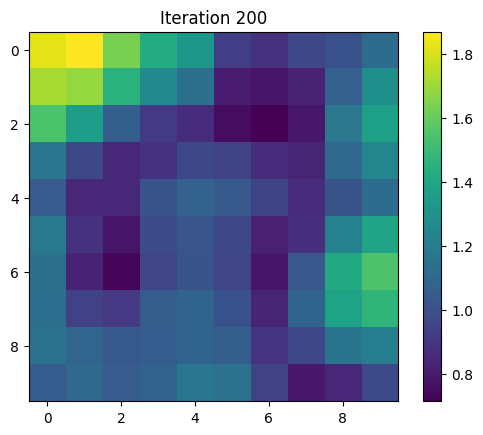

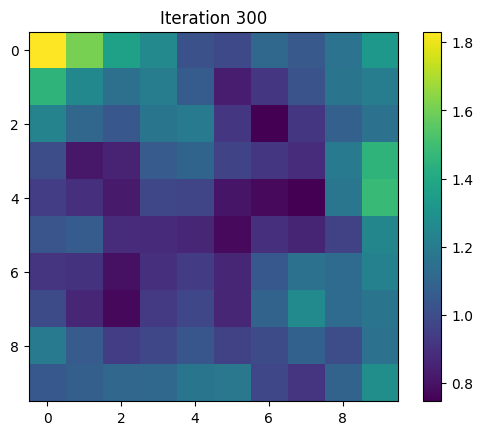

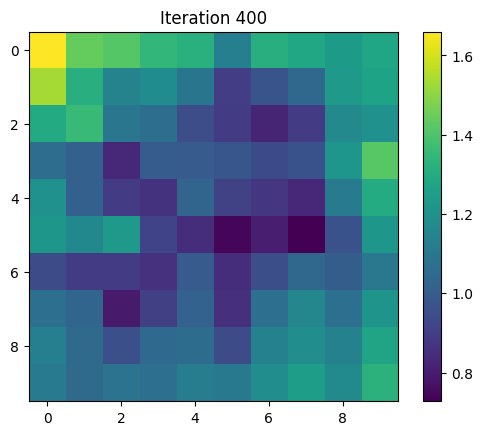

[Grid 10x10]
Accuracy: 0.8859
ARI: 0.1569
Silhouette: 0.4621
Training Time: 22.2125 seconds


In [27]:
# SOM Grid Size: 10x10
som_10 = SOM(grid_shape=(10, 10), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=500)
som_10.train(X_train)

X_train_10 = bmu_to_activation_vectors(X_train, som_10, n_features=8)
X_test_10 = bmu_to_activation_vectors(X_test, som_10, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_10 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_10.fit(X_train_10, y_train)
train_time_10 = time.time() - start

y_pred_10 = clf_10.predict(X_test_10)

print("[Grid 10x10]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_10):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_10):.4f}")
print(f"Silhouette: {silhouette_score(X_test_10, y_pred_10):.4f}")
print(f"Training Time: {train_time_10:.4f} seconds")

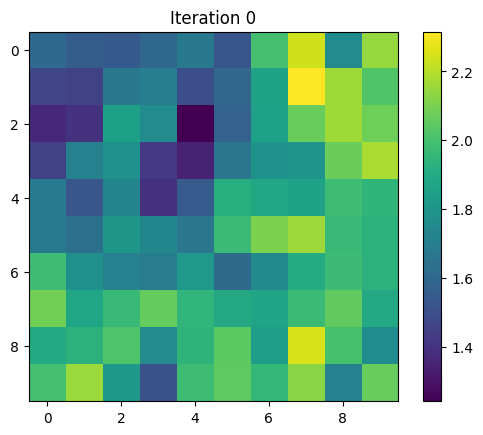

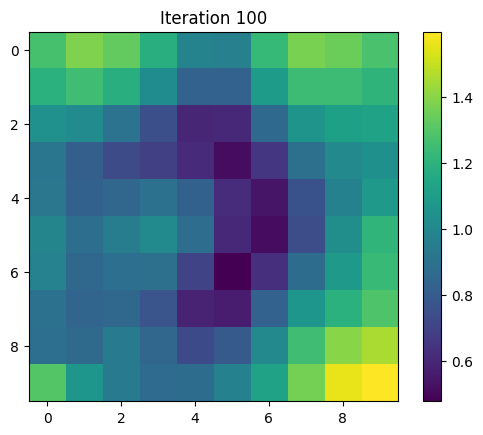

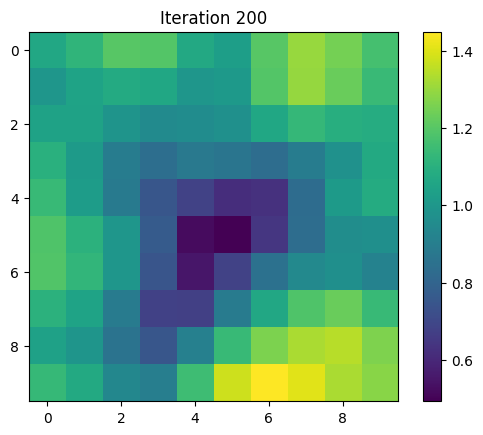

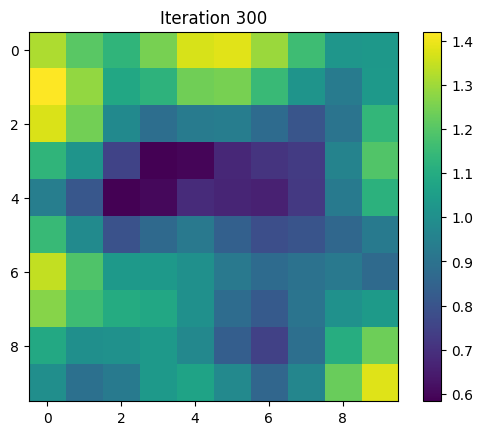

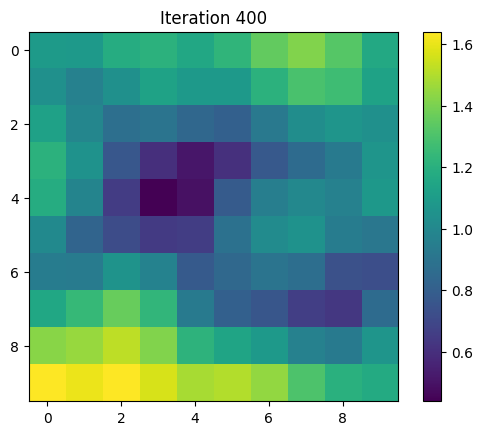

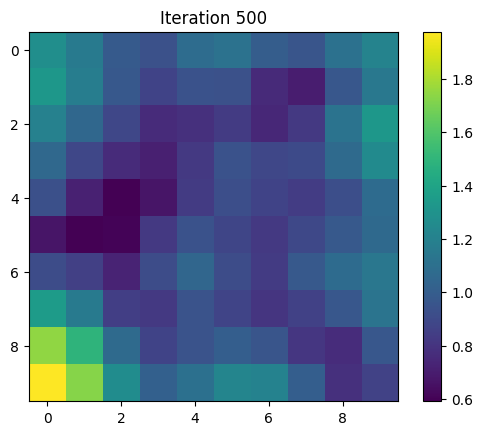

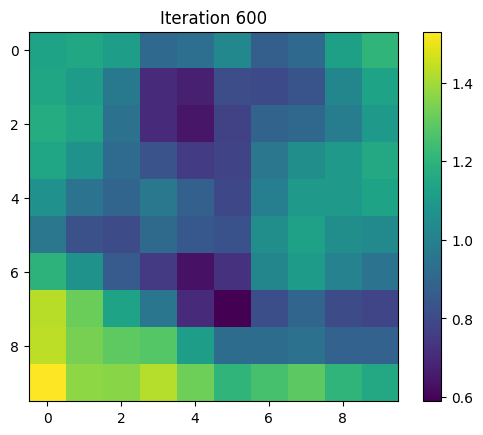

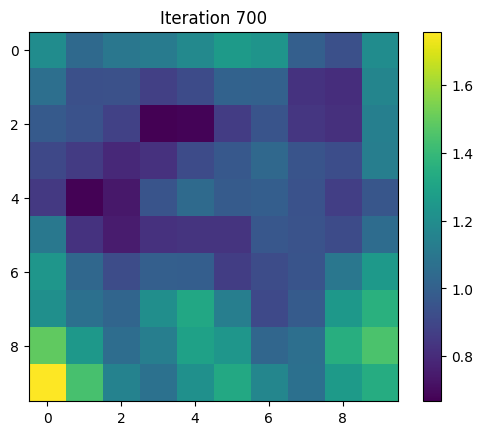

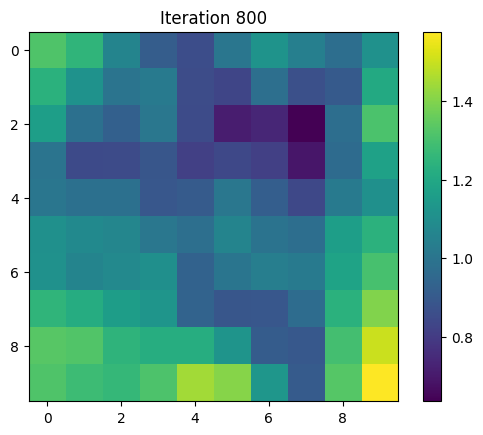

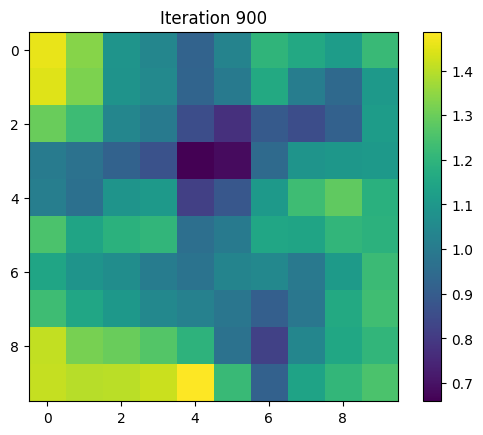

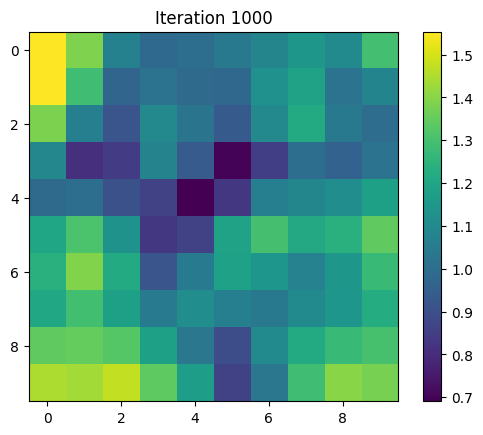

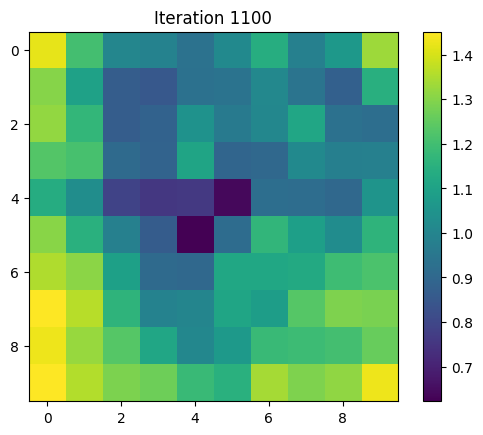

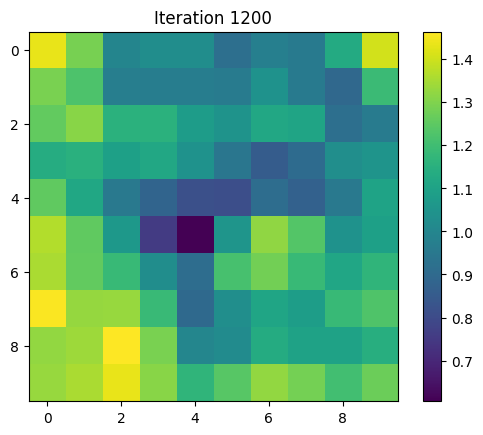

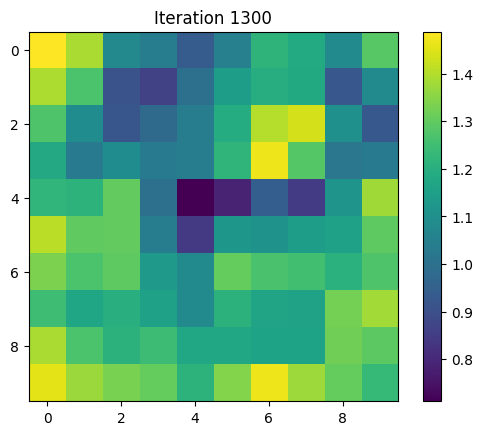

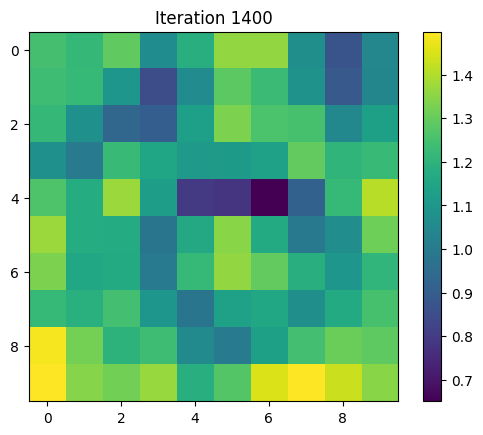

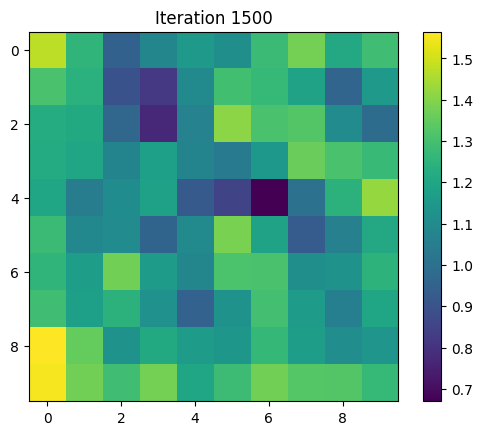

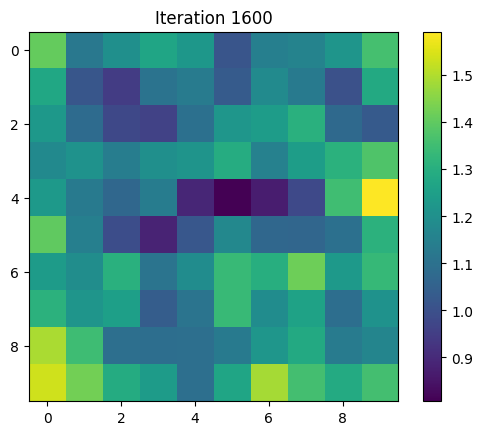

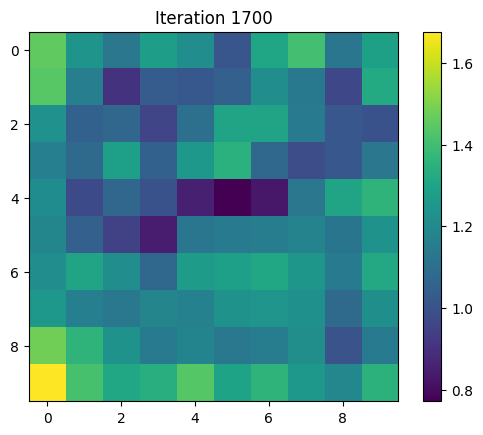

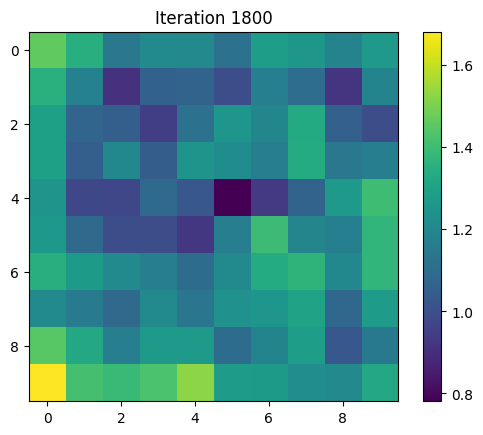

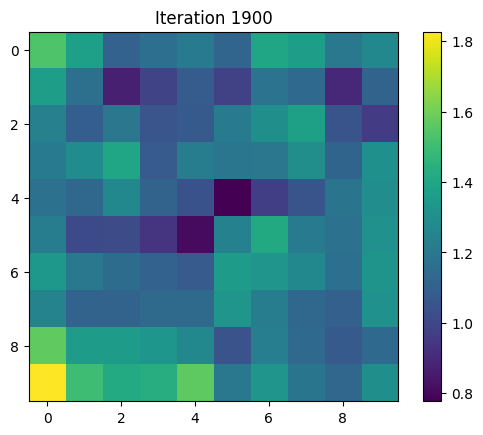

[Grid 10x10]
Accuracy: 0.8883
ARI: 0.1790
Silhouette: 0.4761
Training Time: 20.7746 seconds


In [28]:
# SOM Grid Size: 10x10
som_10 = SOM(grid_shape=(10, 10), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=2000)
som_10.train(X_train)

X_train_10 = bmu_to_activation_vectors(X_train, som_10, n_features=8)
X_test_10 = bmu_to_activation_vectors(X_test, som_10, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_10 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_10.fit(X_train_10, y_train)
train_time_10 = time.time() - start

y_pred_10 = clf_10.predict(X_test_10)

print("[Grid 10x10]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_10):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_10):.4f}")
print(f"Silhouette: {silhouette_score(X_test_10, y_pred_10):.4f}")
print(f"Training Time: {train_time_10:.4f} seconds")

Grid Size: 15x15

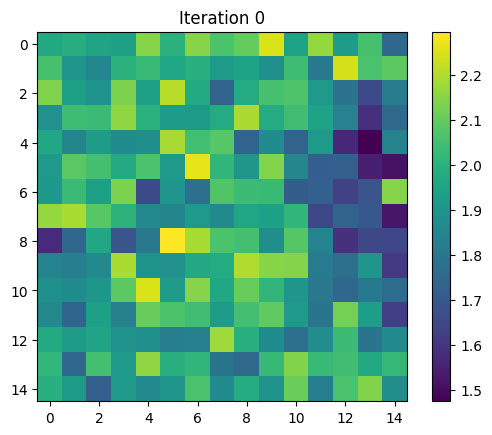

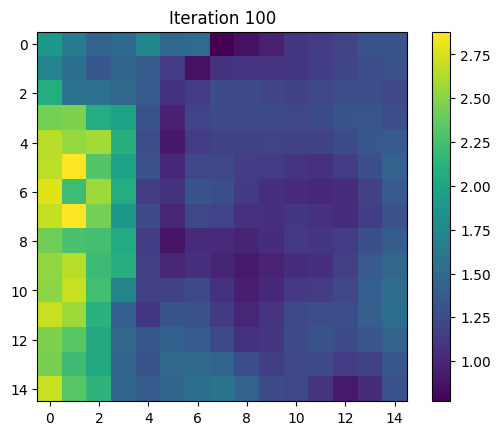

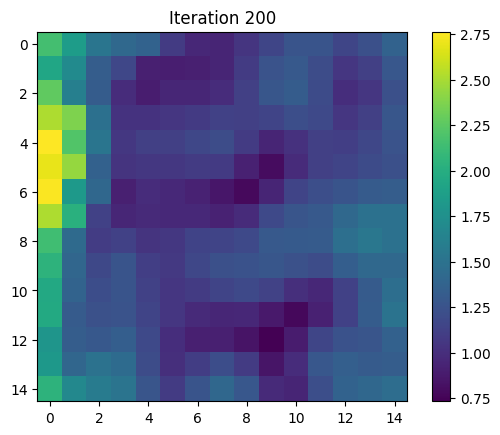

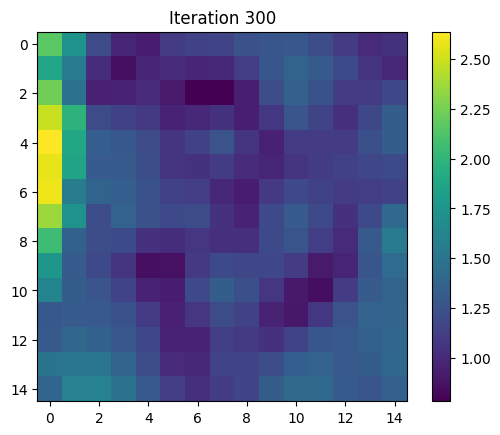

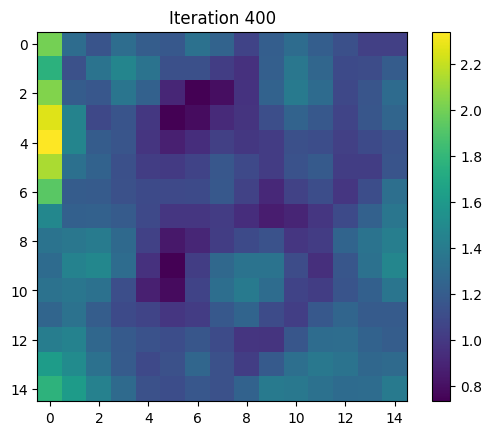

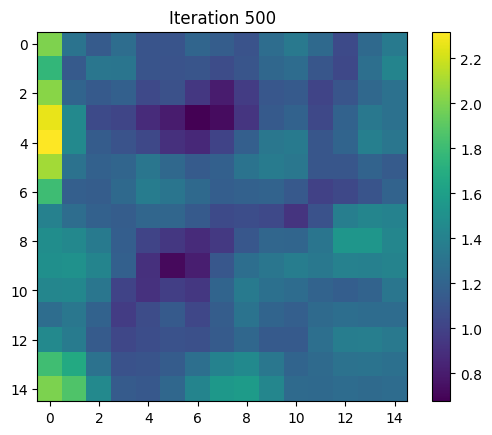

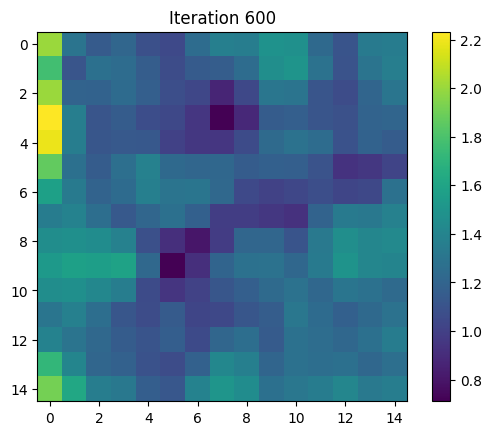

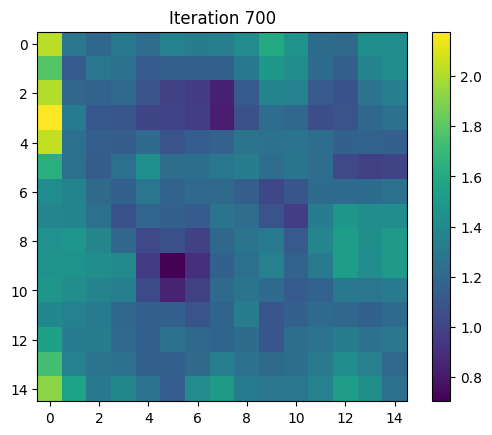

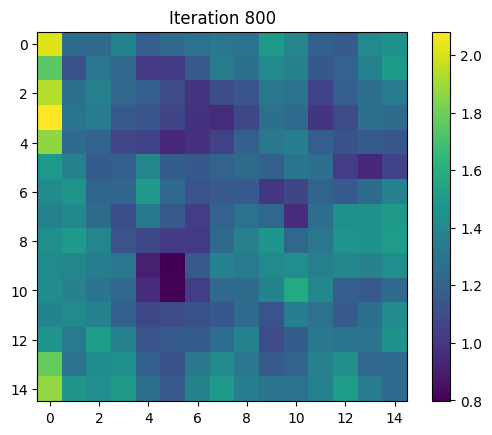

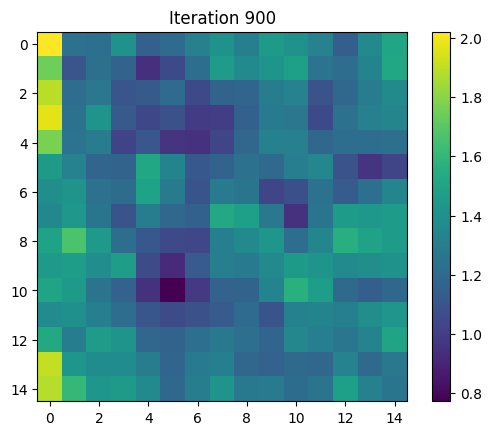

[Grid 15x15]
Accuracy: 0.8888
ARI:      0.1748
Silhouette: 0.4362
Training Time: 19.2706 seconds


In [29]:
# SOM Grid Size: 15x15
som_15 = SOM(grid_shape=(15, 15), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_15.train(X_train)

X_train_15 = bmu_to_activation_vectors(X_train, som_15, n_features=8)
X_test_15 = bmu_to_activation_vectors(X_test, som_15, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_15 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_15.fit(X_train_15, y_train)
train_time_15 = time.time() - start

y_pred_15 = clf_15.predict(X_test_15)

print("[Grid 15x15]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_15):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_15):.4f}")
print(f"Silhouette: {silhouette_score(X_test_15, y_pred_15):.4f}")
print(f"Training Time: {train_time_15:.4f} seconds")


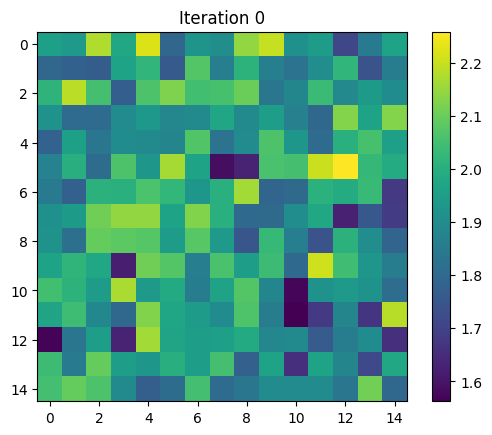

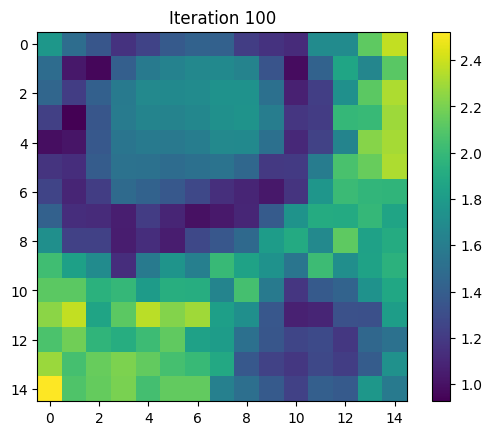

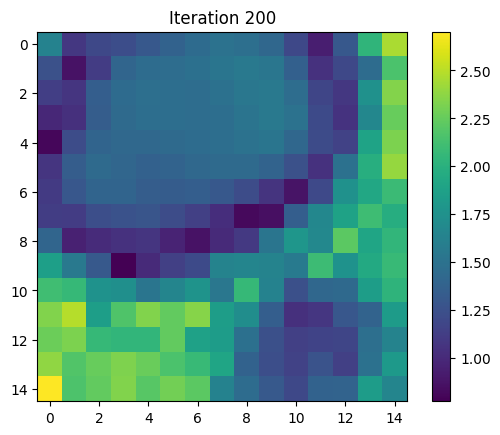

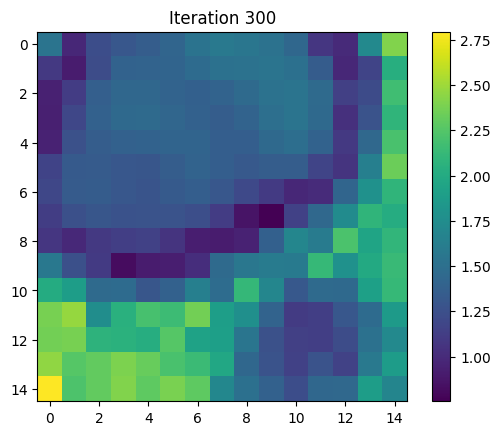

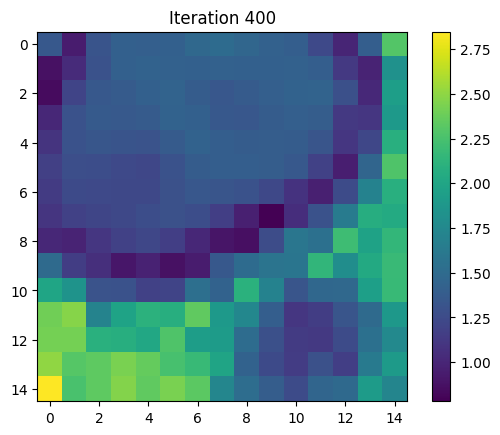

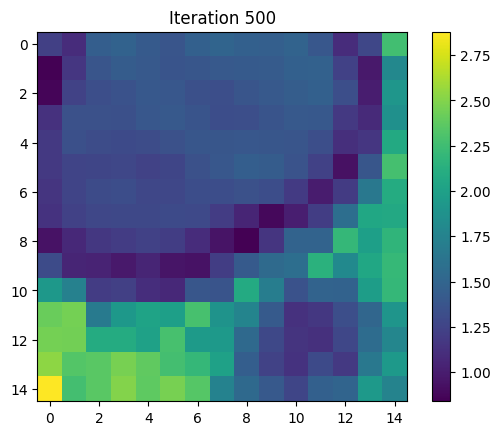

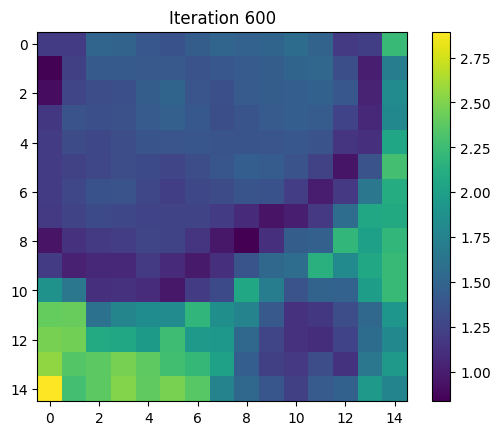

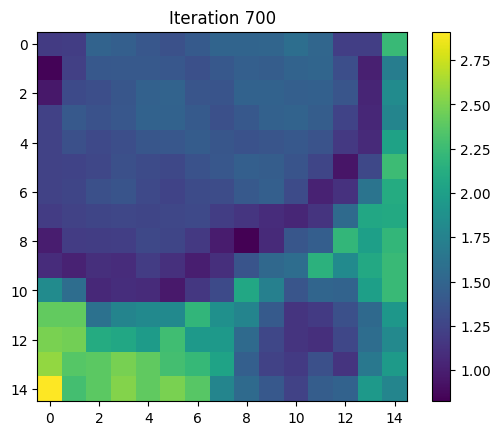

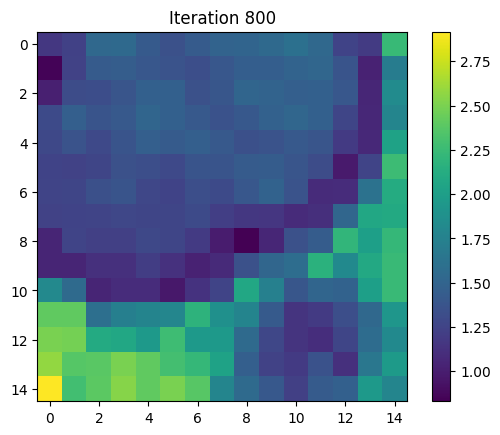

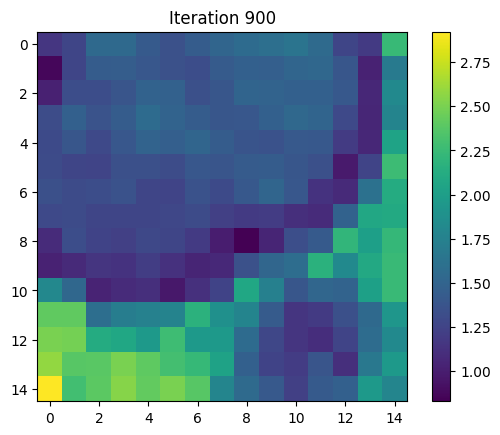

[Grid 15x15]
Accuracy: 0.8874
ARI:      0.1615
Silhouette: 0.4584
Training Time: 23.2587 seconds


In [30]:
# SOM Grid Size: 15x15
som_15 = SOM(grid_shape=(15, 15), input_dim=X_train.shape[1], learning_rate=0.1, radius=2.0, max_iter=1000)
som_15.train(X_train)

X_train_15 = bmu_to_activation_vectors(X_train, som_15, n_features=8)
X_test_15 = bmu_to_activation_vectors(X_test, som_15, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_15 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_15.fit(X_train_15, y_train)
train_time_15 = time.time() - start

y_pred_15 = clf_15.predict(X_test_15)

print("[Grid 15x15]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_15):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_15):.4f}")
print(f"Silhouette: {silhouette_score(X_test_15, y_pred_15):.4f}")
print(f"Training Time: {train_time_15:.4f} seconds")


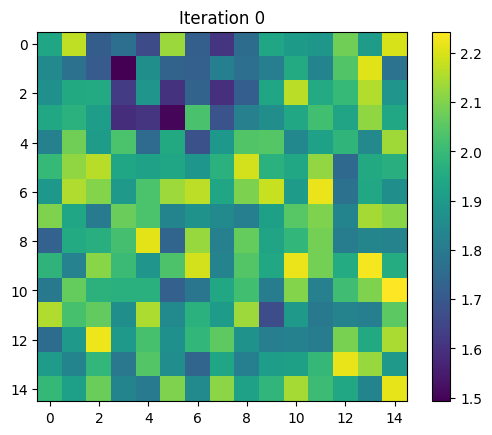

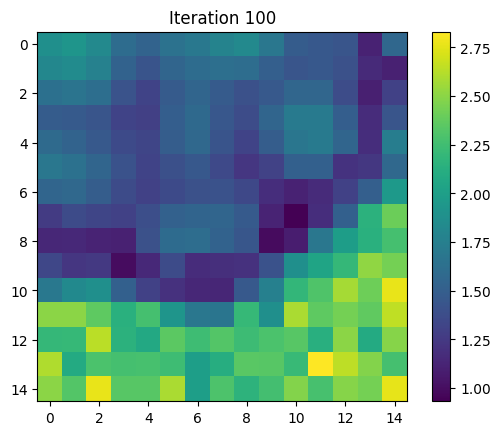

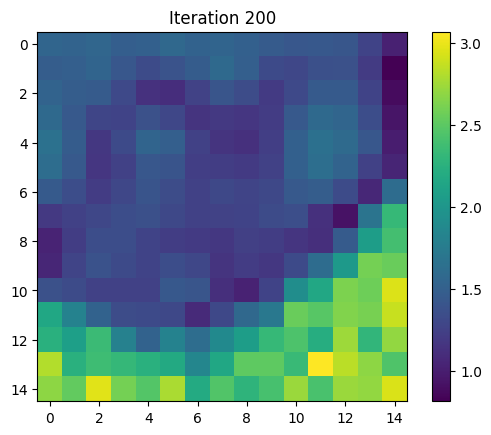

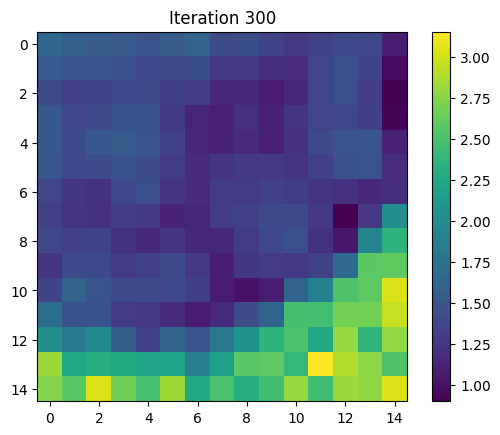

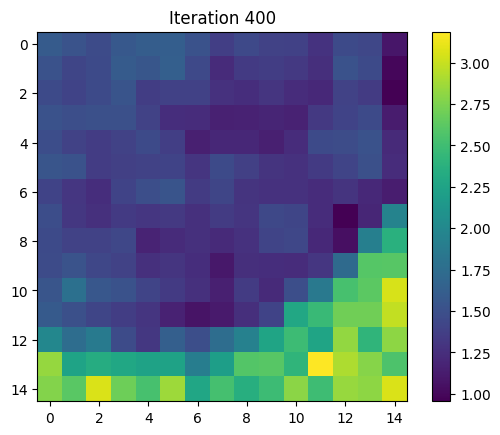

[Grid 15x15]
Accuracy: 0.8846
ARI: 0.0939
Silhouette: 0.3123
Training Time: 23.3029 seconds


In [31]:
# SOM Grid Size: 15x15
som_15 = SOM(grid_shape=(15, 15), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=500)
som_15.train(X_train)

X_train_15 = bmu_to_activation_vectors(X_train, som_15, n_features=8)
X_test_15 = bmu_to_activation_vectors(X_test, som_15, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_15 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_15.fit(X_train_15, y_train)
train_time_15 = time.time() - start

y_pred_15 = clf_15.predict(X_test_15)

print("[Grid 15x15]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_15):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_15):.4f}")
print(f"Silhouette: {silhouette_score(X_test_15, y_pred_15):.4f}")
print(f"Training Time: {train_time_15:.4f} seconds")


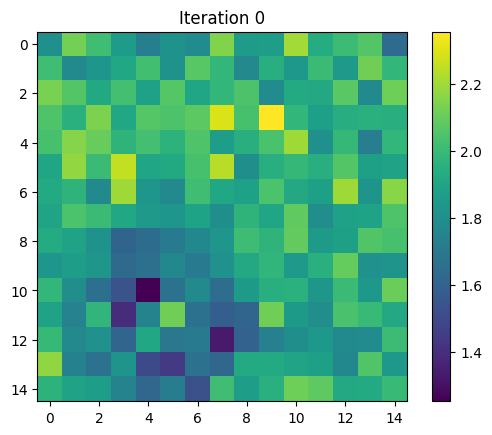

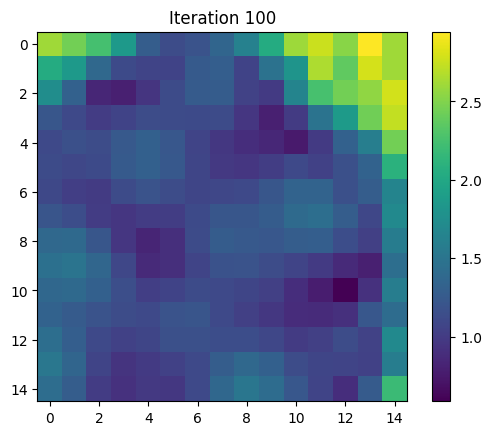

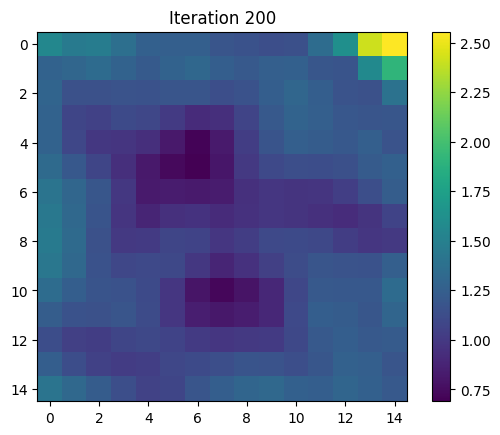

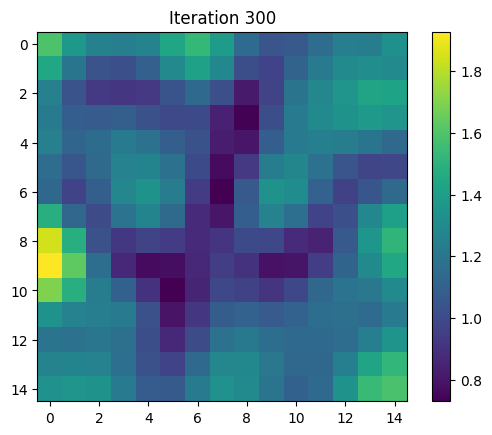

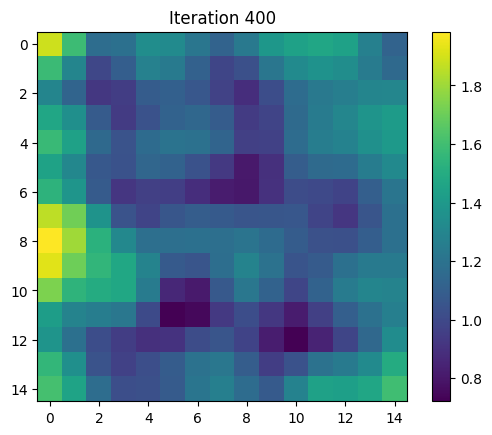

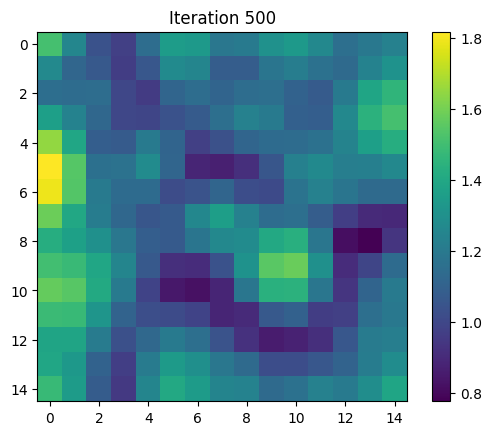

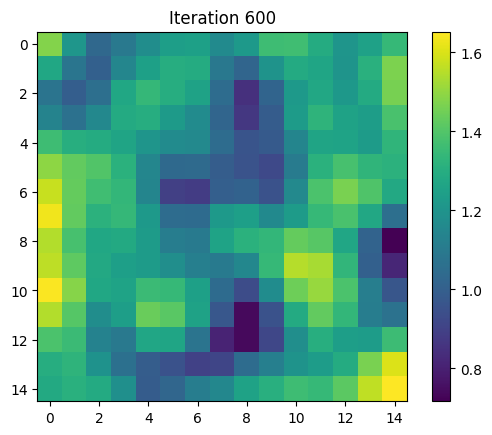

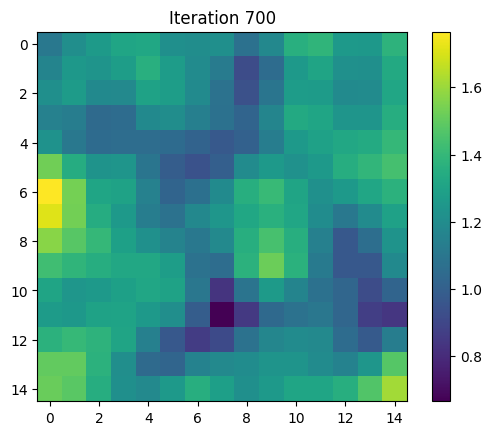

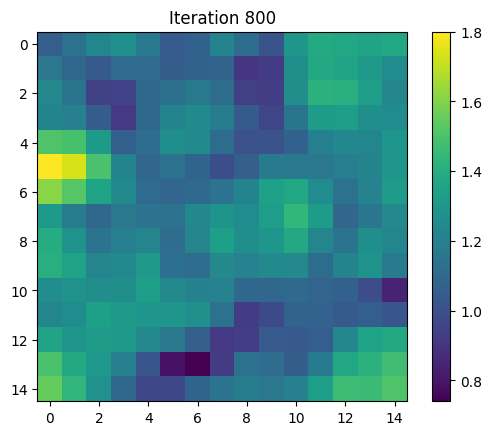

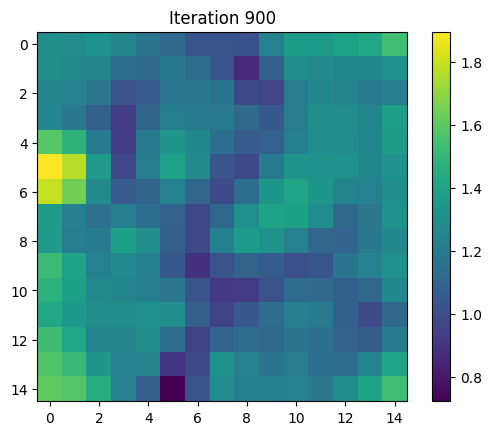

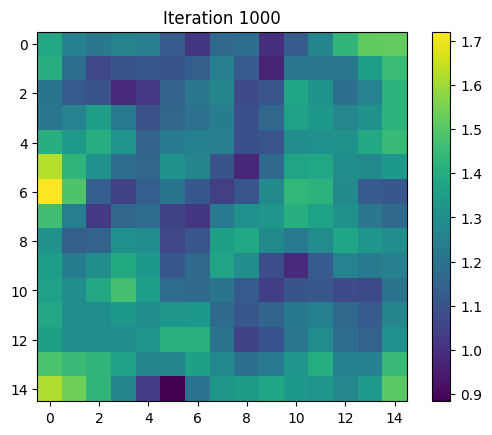

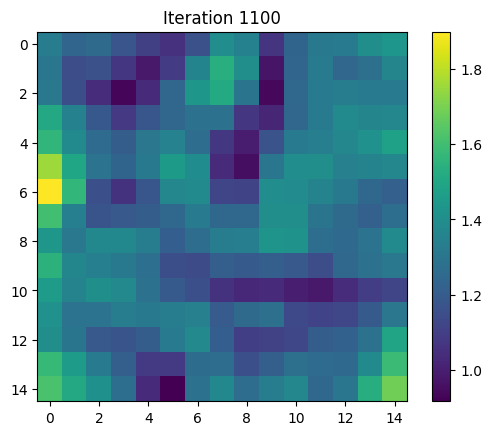

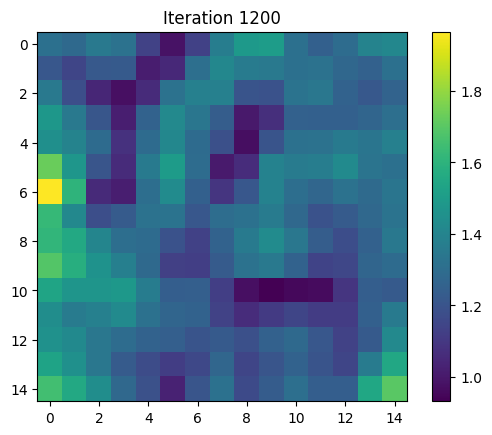

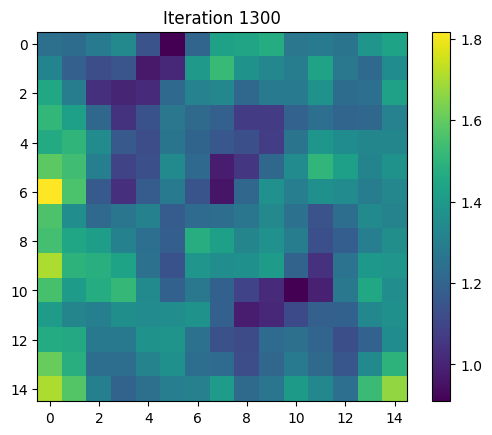

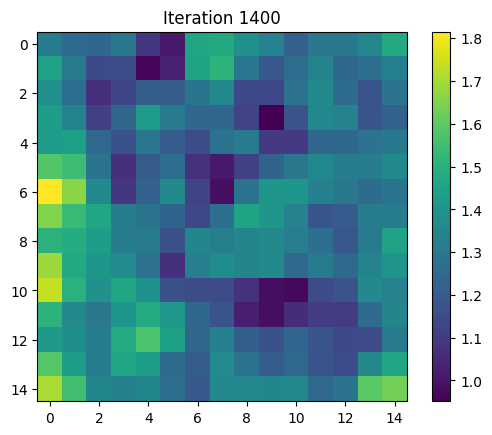

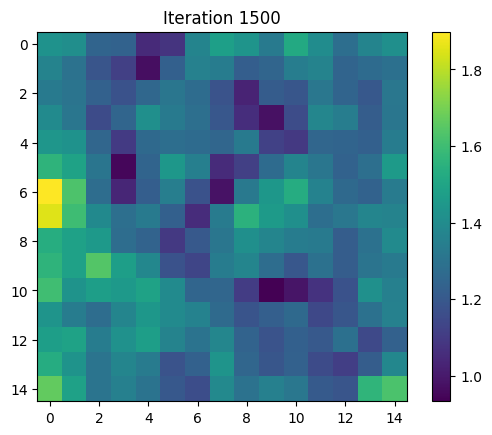

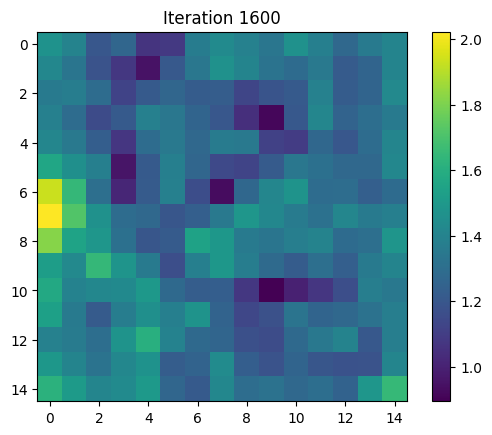

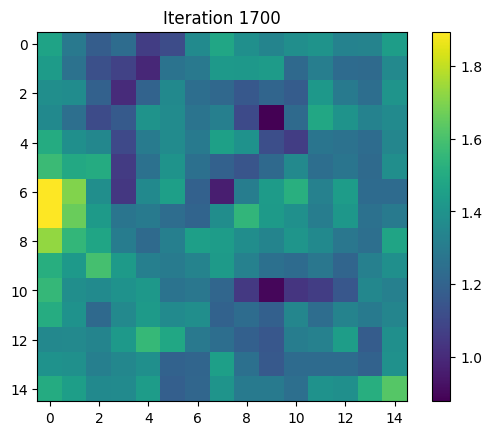

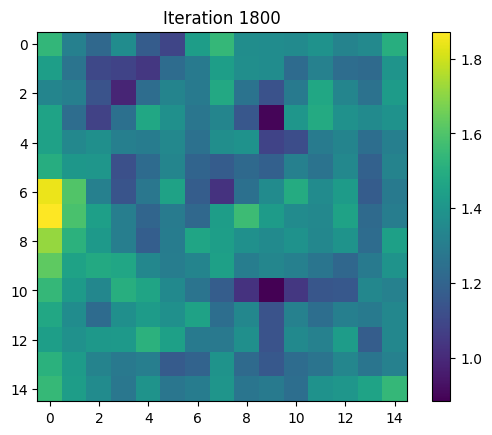

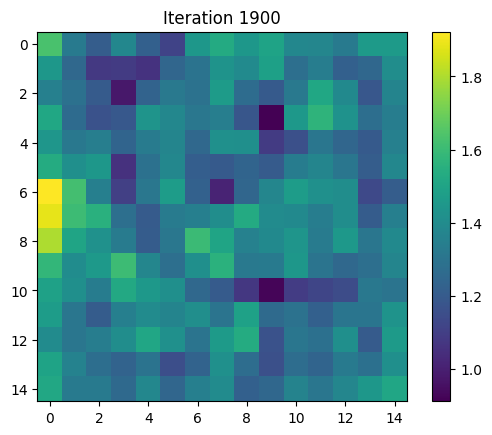

[Grid 15x15]
Accuracy: 0.8853
ARI: 0.1388
Silhouette: 0.3432
Training Time: 17.8907 seconds


In [32]:
# SOM Grid Size: 15x15
som_15 = SOM(grid_shape=(15, 15), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=2000)
som_15.train(X_train)

X_train_15 = bmu_to_activation_vectors(X_train, som_15, n_features=8)
X_test_15 = bmu_to_activation_vectors(X_test, som_15, n_features=8)

# Measure training time for SOM model with 8 dimensions
start = time.time()
clf_15 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_15.fit(X_train_15, y_train)
train_time_15 = time.time() - start

y_pred_15 = clf_15.predict(X_test_15)

print("[Grid 15x15]")
print(f"Accuracy: {accuracy_score(y_test, y_pred_15):.4f}")
print(f"ARI: {adjusted_rand_score(y_test, y_pred_15):.4f}")
print(f"Silhouette: {silhouette_score(X_test_15, y_pred_15):.4f}")
print(f"Training Time: {train_time_15:.4f} seconds")


# Part 4:

Unsupervised Clustering with SOM:
Adjusted Rand Index (ARI): 0.0033
Silhouette Score: 0.04069527781048046


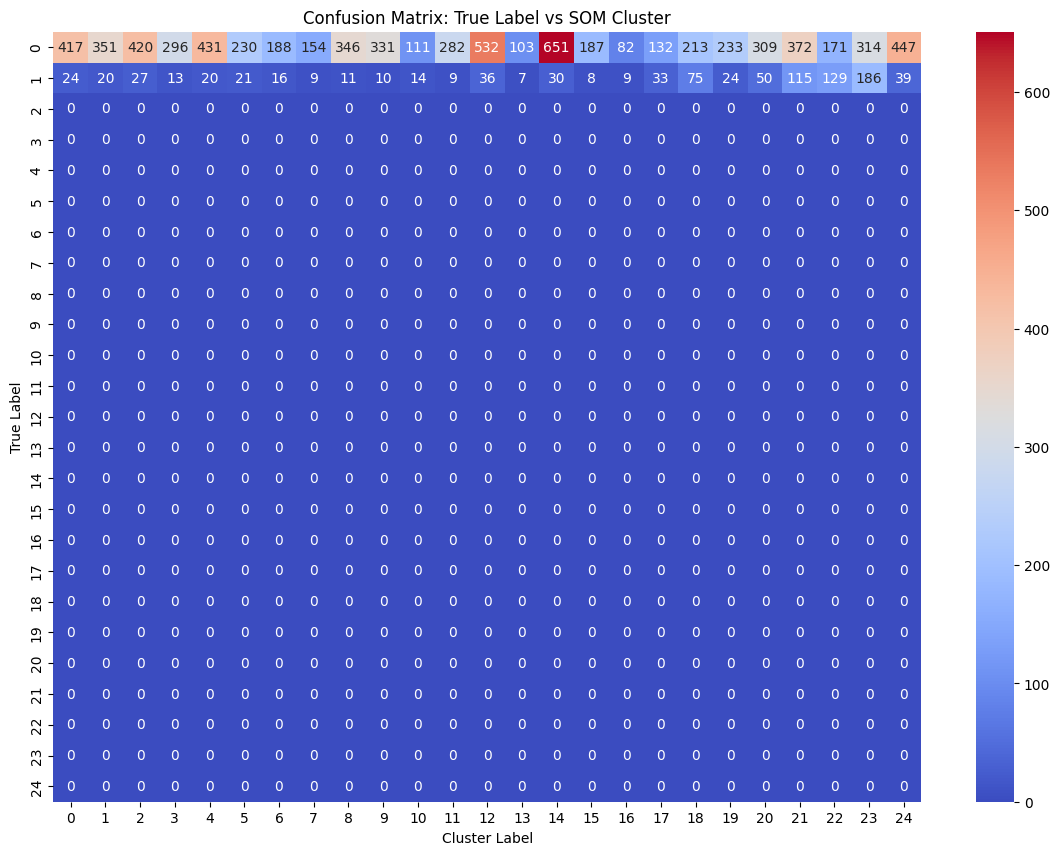

In [33]:
# Assigning clusters by extracting BMU indices for each sample
bmu_indices = som_map.transform(X_test)   # shape = (n_samples, 2)
cluster_labels = bmu_indices[:,0] * som_map.grid_shape[1] + bmu_indices[:,1]

# Evaluate clustering performance 
ari_cluster = adjusted_rand_score(y_test, cluster_labels)
sil_cluster = silhouette_score(X_test, cluster_labels)  if len(np.unique(cluster_labels))>1 else None

print("Unsupervised Clustering with SOM:")
print(f"Adjusted Rand Index (ARI): {ari_cluster:.4f}")
print(f"Silhouette Score: {sil_cluster if sil_cluster is not None else 'N/A'}")

# Display confusion matrix
cm_cluster = confusion_matrix(y_test, cluster_labels)
plt.figure(figsize=(14,10))
sns.heatmap(cm_cluster, annot=True, fmt='d', cmap='coolwarm')
plt.title("Confusion Matrix: True Label vs SOM Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("True Label")
plt.show()

# Part 5:

  method  dim  train_time  accuracy       ari  silhouette
0    PCA    8   21.210346  0.879340  0.194945    0.041123
1    PCA    4   22.911953  0.879097  0.190374    0.082125
2    PCA    2   12.311839  0.876426  0.162581    0.167150
3    SOM    8   18.128609  0.887715  0.171909    0.522324
4    SOM    4   25.755002  0.886623  0.150032    0.491865
5    SOM    2   13.279101  0.881889  0.149861    0.446407


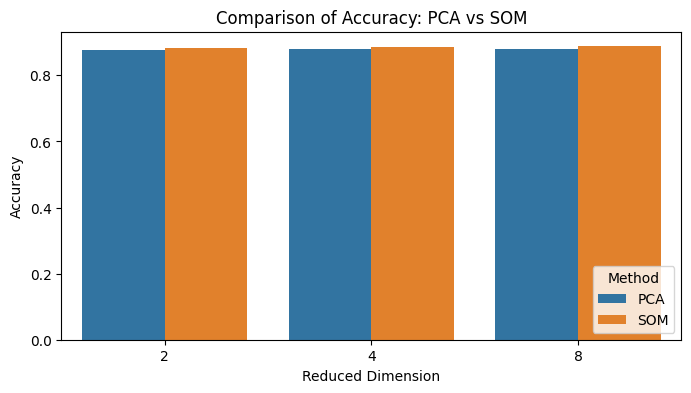

In [34]:
# Reduces X using SOM activation vectors
def get_activation_vectors(X, som_model, k):
    return bmu_to_activation_vectors(X, som_model, n_features=k)

som_models = {8: som_8d, 4: som_4d, 2: som_2d}
dims = [8, 4, 2]
results = []

# Iterate over PCA and SOM for dimensionality reduction
for method in ['PCA', 'SOM']:
    for k in dims:
        if method == 'PCA':
            pca = PCA(n_components=k, random_state=42)
            X_tr = pca.fit_transform(X_train)
            X_ts = pca.transform(X_test)
        else: 
            som_model = som_models[k]
            X_tr = get_activation_vectors(X_train, som_model, k)
            X_ts = get_activation_vectors(X_test,  som_model, k)

        # Training the model and measuring time
        start = time.time()
        clf = RandomForestClassifier(random_state=42, class_weight='balanced')
        clf.fit(X_tr, y_train)
        train_time = time.time() - start

        # Prediction and evaluation metrics
        y_pred = clf.predict(X_ts)
        acc = accuracy_score(y_test, y_pred)
        ari = adjusted_rand_score(y_test, y_pred)
        labs = np.unique(y_pred)
        sil = silhouette_score(X_ts, y_pred) if len(labs) > 1 else None

        results.append({
            'method': method,
            'dim': k,
            'train_time': train_time,
            'accuracy': acc,
            'ari': ari,
            'silhouette': sil
        })

df_results = pd.DataFrame(results)
print(df_results)

# Plot the comparison of accuracy for PCA and SOM
plt.figure(figsize=(8,4))
sns.barplot(data=df_results, x='dim', y='accuracy', hue='method')
plt.title("Comparison of Accuracy: PCA vs SOM")
plt.xlabel("Reduced Dimension")
plt.ylabel("Accuracy")
plt.legend(title="Method", loc='lower right')
plt.show()

# Part 6:

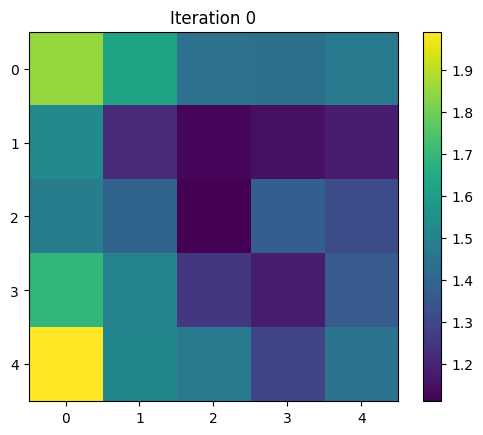

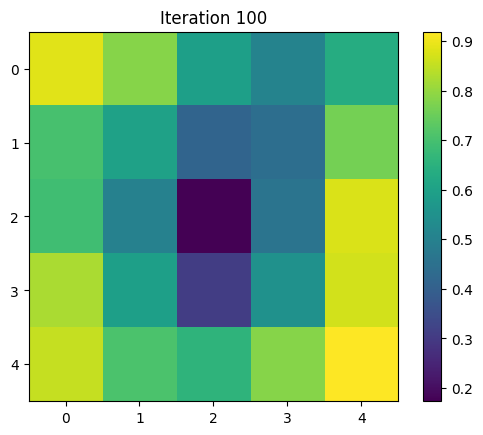

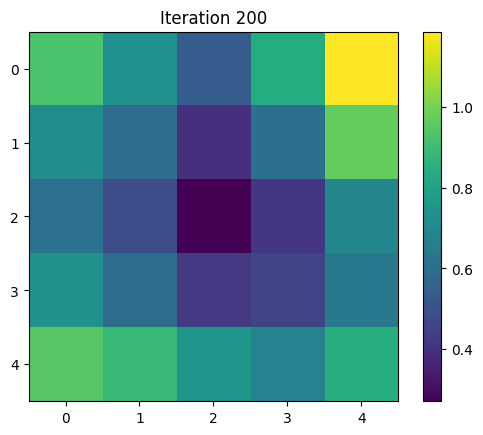

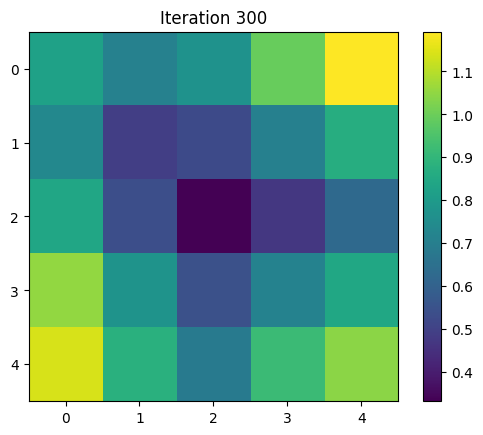

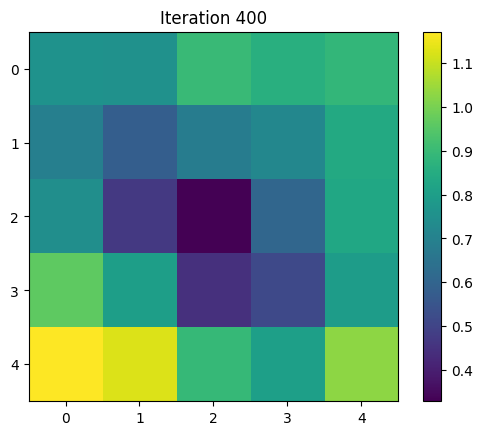

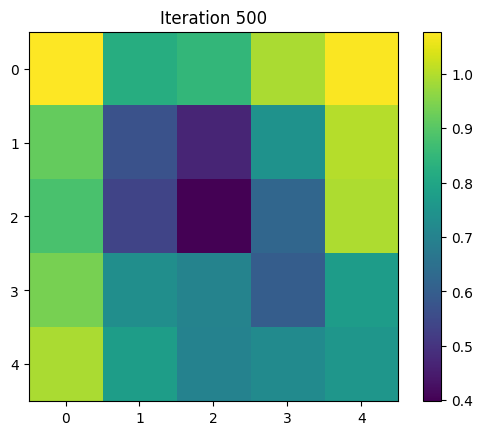

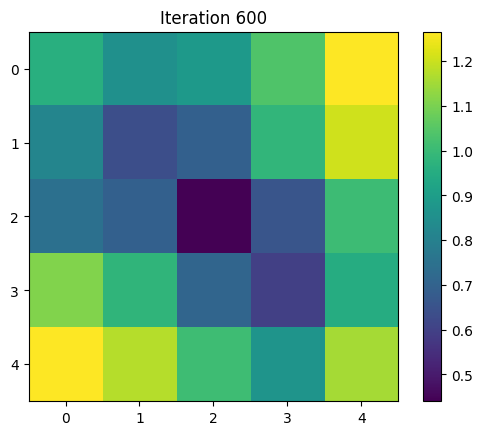

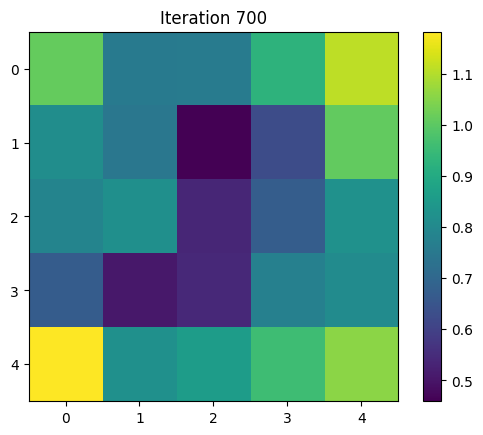

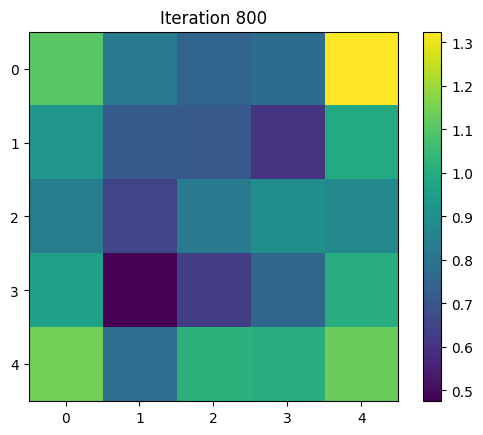

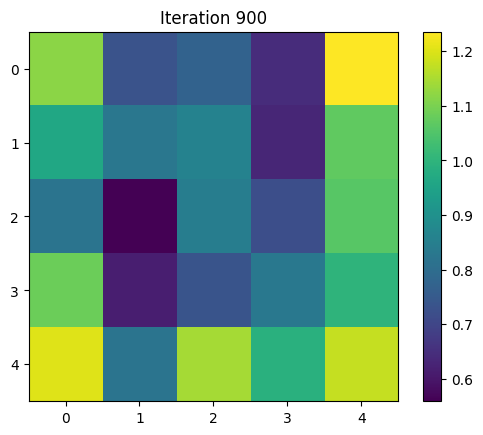

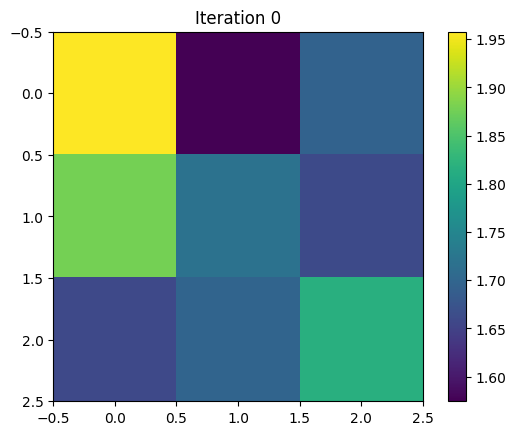

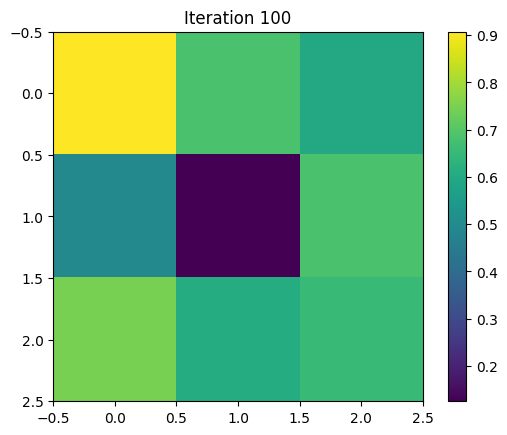

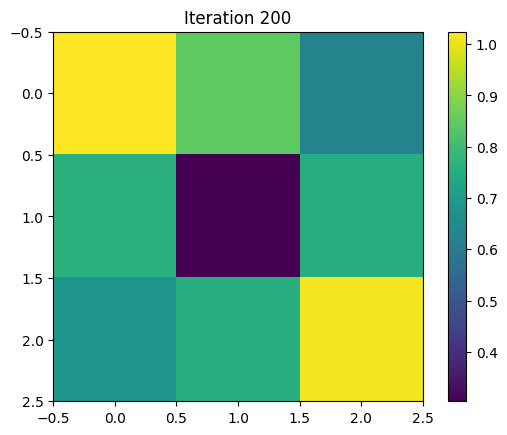

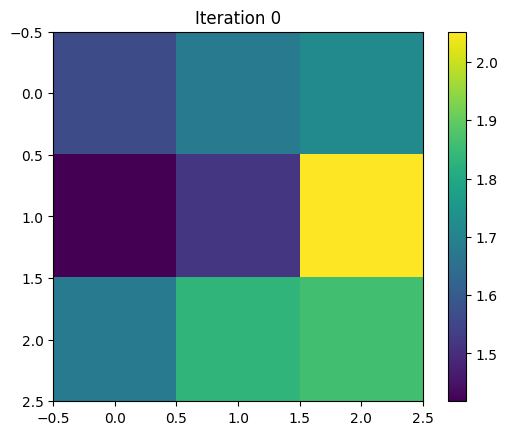

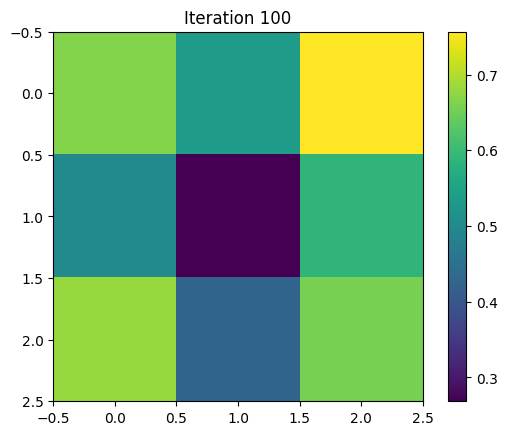

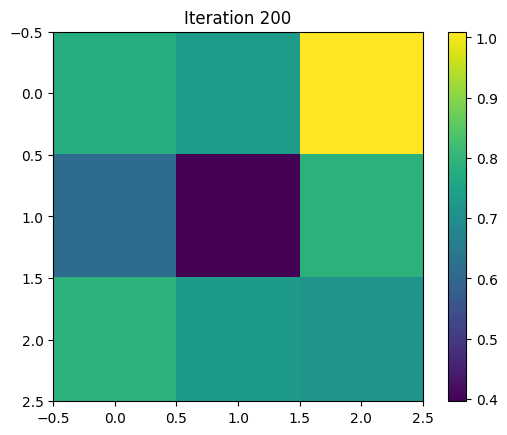

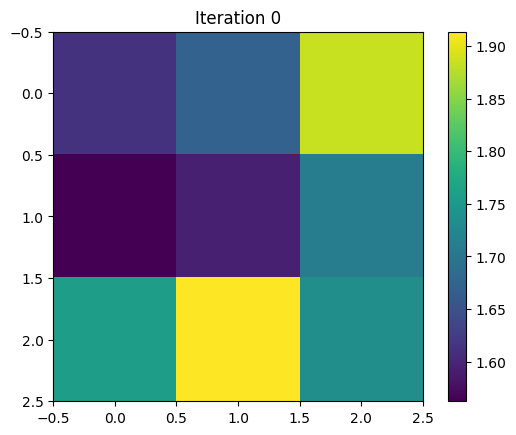

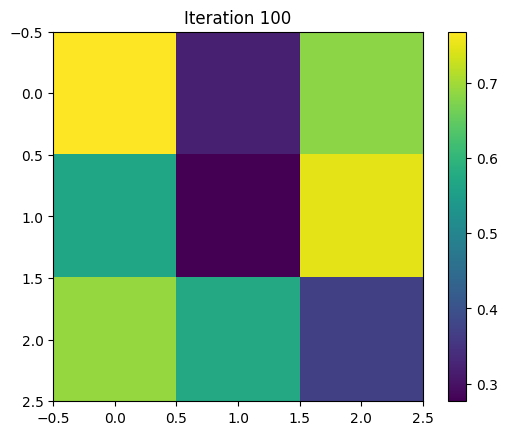

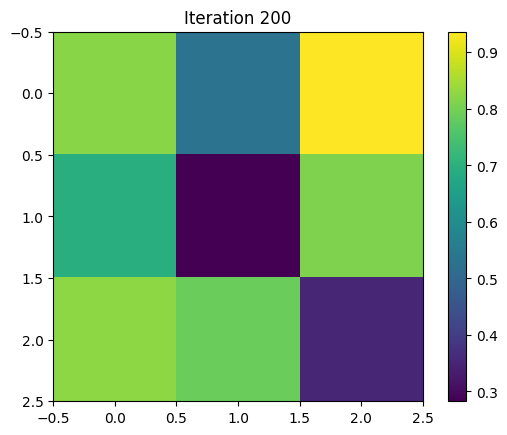

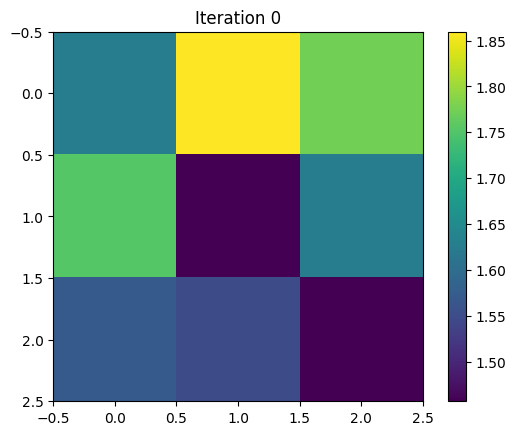

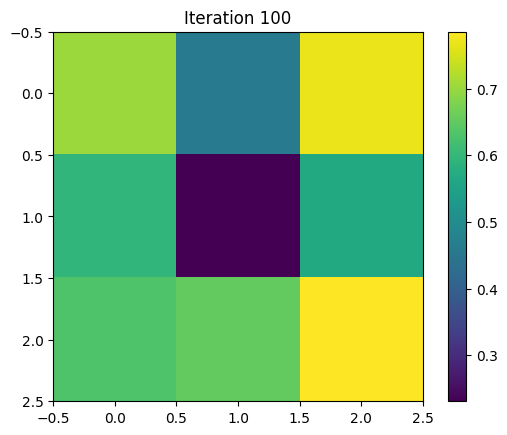

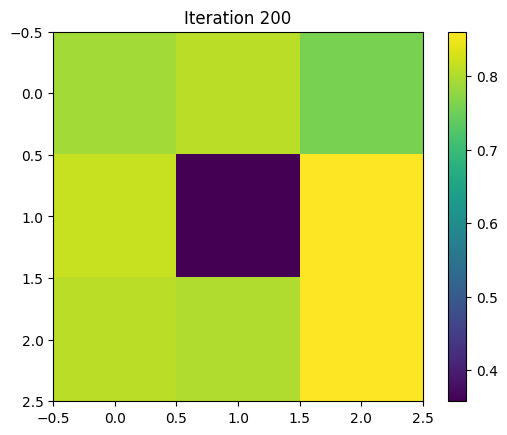

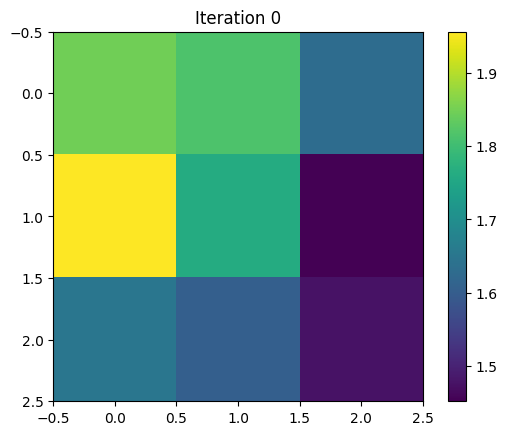

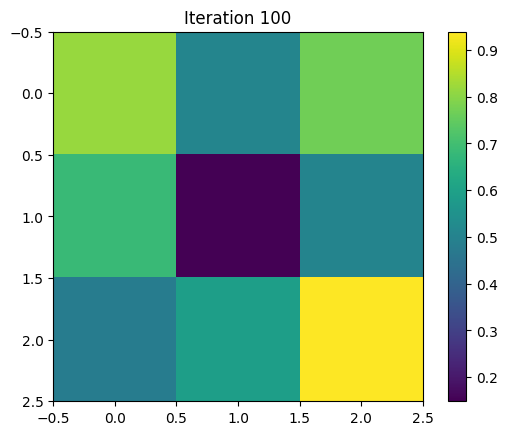

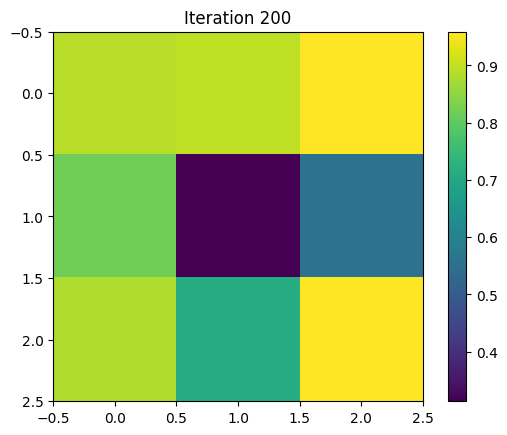

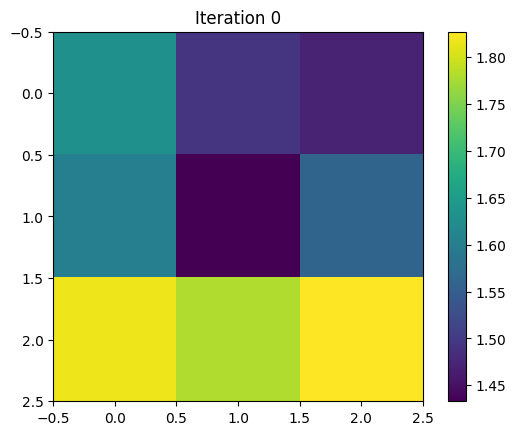

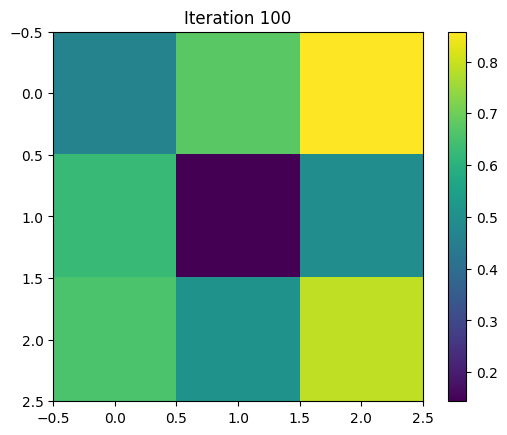

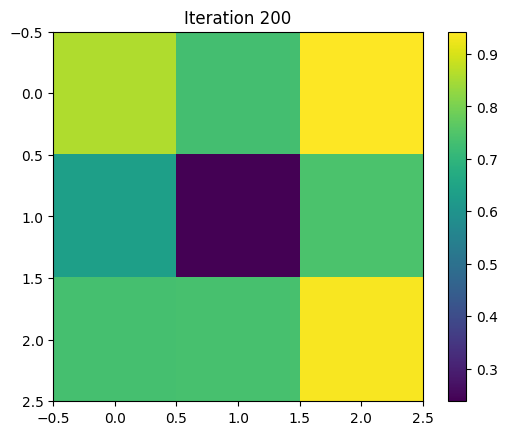

In [ ]:
som_coarse = SOM(grid_shape=(5, 5), input_dim=X_train.shape[1], learning_rate=0.5, radius=2.0, max_iter=1000)
som_coarse.train(X_train)

bmu_train_coarse = som_coarse.transform(X_train) 

from collections import defaultdict
threshold = int(0.05 * len(X_train))  

region_data = defaultdict(list)
for idx, bmu in enumerate(bmu_train_coarse):
    region_data[tuple(bmu)].append(X_train.values[idx])

sub_soms = {}
for bmu_coord, samples in region_data.items():
    if len(samples) >= threshold:
        samples = np.array(samples)
        som_sub = SOM(grid_shape=(3, 3), input_dim=X_train.shape[1],
                            learning_rate=0.3, radius=1.0, max_iter=300)
        som_sub.train(pd.DataFrame(samples, columns=X_train.columns))
        sub_soms[bmu_coord] = som_sub

def hierarchical_embedding(X, som_coarse, sub_soms):
    emb = []
    bmus_coarse = som_coarse.transform(X)
    for i, x in enumerate(X.values):
        bc = tuple(bmus_coarse[i])
        if bc in sub_soms:
            bmu_sub = sub_soms[bc].find_bmu(x)
        else:
            bmu_sub = (-1, -1)
        emb.append([bc[0], bc[1], bmu_sub[0], bmu_sub[1]])
    return np.array(emb)

X_train_h = hierarchical_embedding(X_train, som_coarse, sub_soms)
X_test_h  = hierarchical_embedding(X_test,  som_coarse, sub_soms)


In [ ]:
clf_h = RandomForestClassifier(random_state=42, class_weight='balanced')
start = time.time()
clf_h.fit(X_train_h, y_train)
t_h = time.time() - start

y_pred_h = clf_h.predict(X_test_h)
acc_h = accuracy_score(y_test, y_pred_h)
ari_h = adjusted_rand_score(y_test, y_pred_h)
labels_h = np.unique(y_pred_h)
sil_h = silhouette_score(X_test_h, y_pred_h) if len(labels_h)>1 else None

print("Hierarchical SOM Embedding:")
print(f"Accuracy: {acc_h:.4f}")
print(f"ARI:      {ari_h:.4f}")
print(f"Silhouette: {sil_h if sil_h is not None else 'N/A'}")
print(f"Training Time: {t_h:.4f} seconds")

Hierarchical SOM Embedding:
Accuracy: 0.7645
ARI:      0.1592
Silhouette: 0.11374255096235171
Training Time: 2.9253 seconds
